# Collate all of the FROC data into a single file

In [32]:
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt

fontsize = 15

In [33]:

fpps_recode = {
    0 : 0.125,
    1 : 0.25,
    2 : 0.5,
    3 : 1,
    4 : 2,
    5 : 4,
    6 : 8
}

froc_paths = Path('results').rglob('*_froc.json')
froc_data = pd.concat([
    (
        pd.DataFrame(category_data)
        .reset_index()
        .rename(columns={'index': 'fpps'})
        .assign(fpps=lambda df: df['fpps'].map(fpps_recode))
        .assign(category=category_json)
        .assign(path=froc_path.as_posix())
    )
    for froc_path in froc_paths
    for category_json, category_data in json.load(froc_path.open()).items()
])

froc_data[['a','dataset','filename']] = froc_data.path.str.split('/', expand=True)
froc_data['model']=froc_data.filename.str.split('_').str[0]
froc_data['flavour']=froc_data.filename.str.split('_').str[1].str.cat(froc_data.filename.str.split('_').str[2], sep='_')
froc_data['error']=froc_data['high_sens'] - froc_data['low_sens']
froc_data.drop(columns=['path','a','filename'], inplace=True)
froc_data.to_csv('froc_data.csv', index=False)
froc_data.query("flavour == 'test_balanced' and category.str.lower() in ['male','female']")

,fpps,mean_sens,low_sens,high_sens,category,dataset,model,flavour,error
0,0.125,0.173,0.098,0.253,MALE,summit,grt123,test_balanced,0.155
1,0.250,0.218,0.133,0.310,MALE,summit,grt123,test_balanced,0.177
2,0.500,0.309,0.210,0.415,MALE,summit,grt123,test_balanced,0.205
3,1.000,0.392,0.285,0.504,MALE,summit,grt123,test_balanced,0.219
4,2.000,0.456,0.351,0.560,MALE,summit,grt123,test_balanced,0.209
...,...,...,...,...,...,...,...,...,...
2,0.500,0.451,0.311,0.614,Female,lsut,ticnet,test_balanced,0.303
3,1.000,0.538,0.423,0.676,Female,lsut,ticnet,test_balanced,0.253
4,2.000,0.644,0.516,0.787,Female,lsut,ticnet,test_balanced,0.271
5,4.000,0.708,0.568,0.850,Female,lsut,ticnet,test_balanced,0.282


# Collate CI

In [34]:
import json
import numpy as np

# Collate the mAP scores
CI_paths = Path('results').rglob('*_ci.json')
CI_paths = pd.concat([
    (
        pd.DataFrame.from_dict(json.load(p.open()), orient='index')
        .reset_index()
        .rename(columns={'index':'category', 0:'ci_lower', 1:'ci_upper'})
        .assign(ci=lambda df: np.round(df['ci_lower'],2).astype(str).str.cat(np.round(df['ci_upper'],2).astype(str), sep=' - '))
        .assign(path=p.as_posix())
    )
    for p in CI_paths
])

CI_paths['dataset'] = CI_paths.path.str.split('/').str[1]
CI_paths['x'] = CI_paths.path.str.split('/').str[-1]
CI_paths[['model','p1','p2','d1']] = CI_paths.x.str.split('_', expand=True)
CI_paths['flavour'] = CI_paths.p1.str.cat(CI_paths.p2, sep='_')

ci_data = CI_paths.filter(['dataset', 'model','flavour','category','iou','ci_lower','ci_upper'])
ci_data.to_csv('results/cis.csv', index=False)

ci_data.query('dataset == "summit" and flavour == "white_only"')

,dataset,model,flavour,category,ci_lower,ci_upper
0,summit,detection,white_only,MALE_vs_FEMALE,-1.156879,0.298947
0,summit,grt123,white_only,MALE_vs_FEMALE,-0.756381,0.789223
0,summit,ticnet,white_only,MALE_vs_FEMALE,-1.368538,0.190327


# Plot the Error Bar

********************************************************************************
Flavour: test_balanced


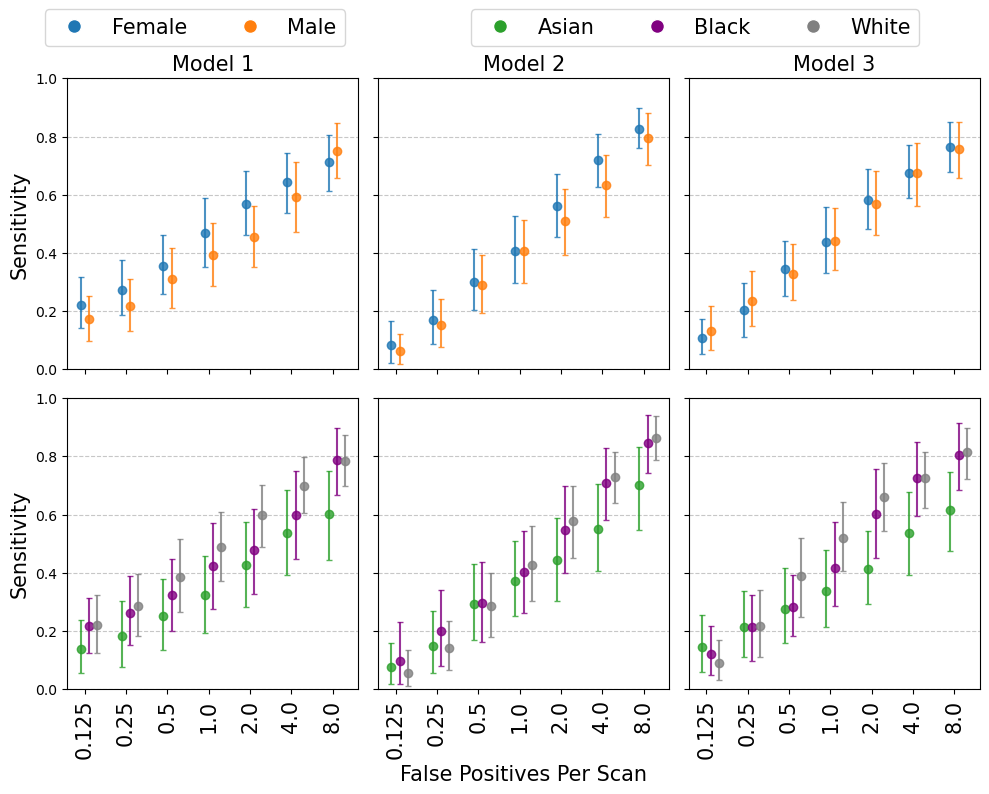

********************************************************************************
Flavour: male_only


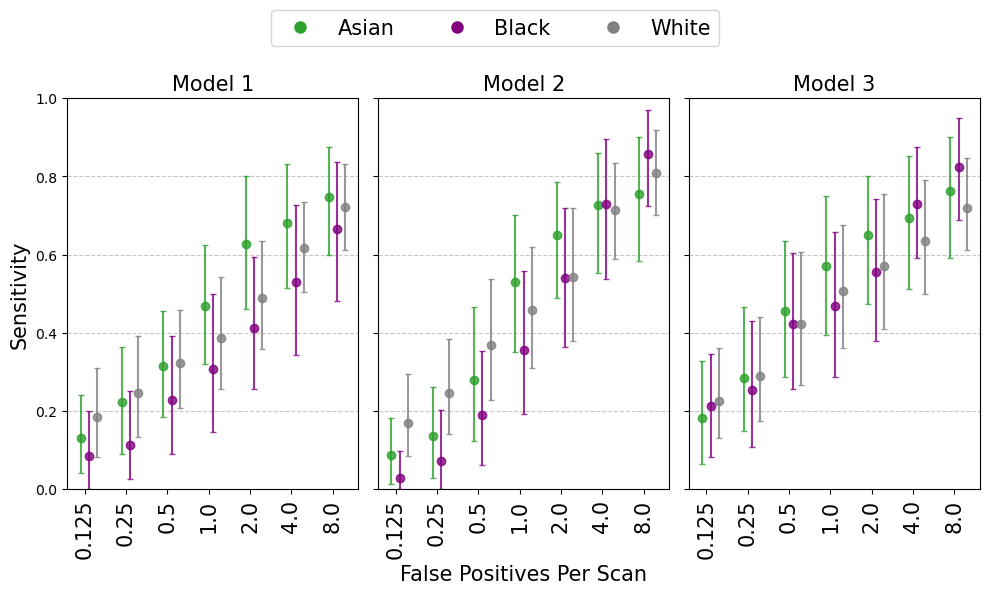

********************************************************************************
Flavour: white_only


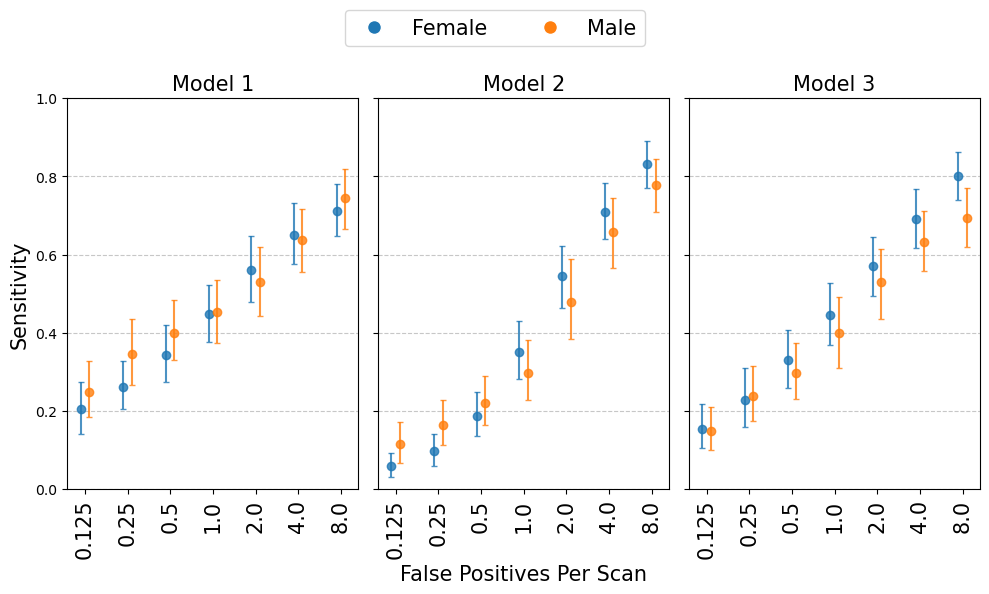

********************************************************************************
Flavour: test_balanced


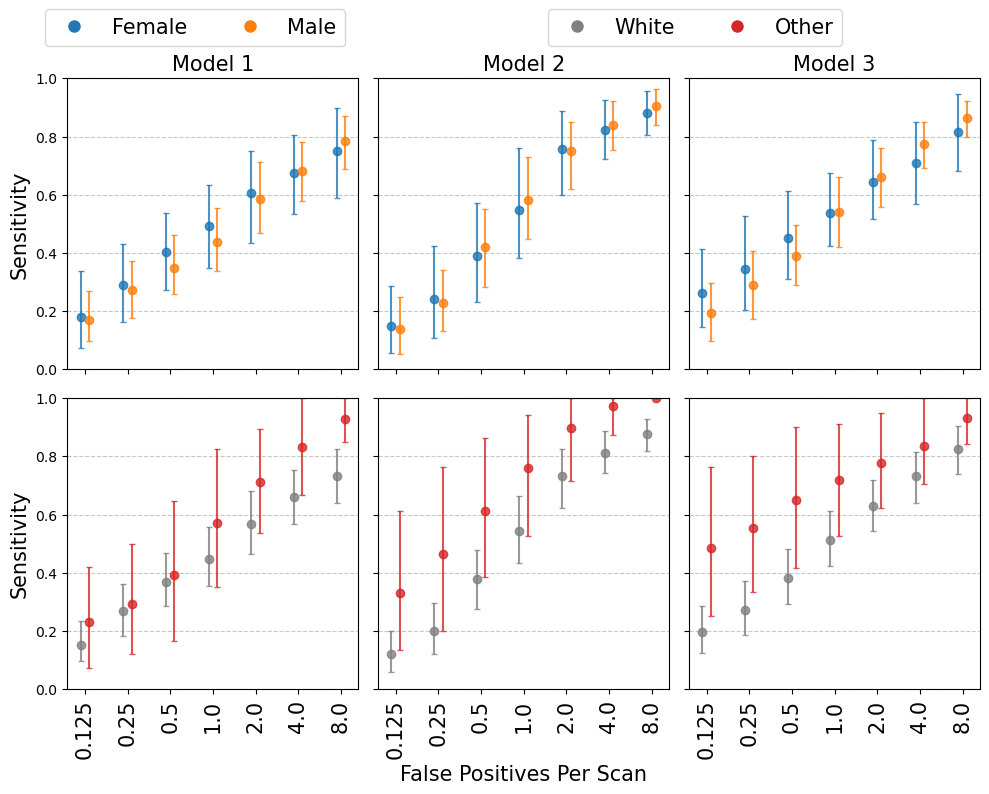

In [35]:
from matplotlib.lines import Line2D

def plot_frocs(dataset, map_data, flavour):
      df = map_data.query('dataset == @dataset and flavour == @flavour')

      if flavour == 'male_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True, sharex=True)
      elif flavour == 'white_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True, sharex=True)
      else:
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8), sharey=True, sharex=True)

      bar_width = 0.2
      categories_top = ['FEMALE', 'MALE'] if dataset == 'summit' else ['Female', 'Male']
      categories_bottom = ['Asian or Asian British', 'Black', 'White'] if dataset == 'summit' else ['White', 'Other']

      model_mappings = {
            'grt123': 'Model 1',
            'detection': 'Model 2',
            'ticnet': 'Model 3'
      }


      # Define color-blind-friendly palette
      colors = {
            'Female': '#1f77b4',  # Blue
            'Male': '#ff7f0e',    # Orange
            'Asian': '#2ca02c',   # Green
            'Black': 'purple',   # Yellow
            'White': 'grey',   # Grey
            'Other': '#d62728'    # Red
      }

      for i, model in enumerate(['grt123', 'detection', 'ticnet']):
            df_model = df.query('model == @model')

            if flavour != 'male_only':
                  ax_top = axes[0, i] if flavour != 'white_only' else axes[i]
                  for j, category in enumerate(categories_top):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['fpps'].unique()))
                        ax_top.errorbar(
                              positions + j * bar_width,
                              subset['mean_sens'],
                              yerr=[
                                    subset['mean_sens'] - subset['low_sens'],
                                    subset['high_sens'] - subset['mean_sens']
                              ],
                              fmt='o',
                              label=category.replace('FEMALE', 'Female').replace('MALE', 'Male'),
                              capsize=2,
                              alpha=0.8,
                              color=colors[category.replace('FEMALE', 'Female').replace('MALE', 'Male')]
                        )
                        ax_top.set_title(f'{model_mappings[model]}', fontsize=fontsize)
                        ax_top.set_xticks(positions + bar_width / 2)
                        ax_top.set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=90)
                        ax_top.grid(axis="y", linestyle="--", alpha=0.7)
                        ax_top.set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

                        if i == 0:
                              ax_top.set_ylabel('Sensitivity', fontsize=fontsize)

                        if i == 1 and flavour == 'white_only':
                              ax_top.set_xlabel('False Positives Per Scan', fontsize=fontsize)                              

            if flavour != 'white_only':
                  ax_bottom = axes[1, i] if flavour != 'male_only' else axes[i]
                  for j, category in enumerate(categories_bottom):
                        subset = df_model.query('category == @category')
                        positions = np.arange(len(subset['fpps'].unique()))
                        ax_bottom.errorbar(
                              positions + j * bar_width,
                              subset['mean_sens'],
                              yerr=[
                                    subset['mean_sens'] - subset['low_sens'],
                                    subset['high_sens'] - subset['mean_sens']
                              ],
                              fmt='o',
                              label=category.replace('Asian or Asian British', 'Asian'),
                              capsize=2,
                              alpha=0.8,
                              color=colors[category.replace('Asian or Asian British', 'Asian')]
                        )
                        ax_bottom.set_xticks(positions + bar_width / 2)
                        ax_bottom.set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=90)
                        ax_bottom.grid(axis="y", linestyle="--", alpha=0.7)
                        ax_bottom.set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

                  if i == 0:
                        ax_bottom.set_ylabel('Sensitivity', fontsize=fontsize)

                  if i == 1:
                        ax_bottom.set_xlabel('False Positives Per Scan', fontsize=fontsize)

                  if flavour == 'male_only':
                        ax_bottom.set_title(f'{model_mappings[model]}', fontsize=fontsize)

            

      # Create legends for sex and ethnic group
      if flavour in ['test_balanced', 'white_only']:
            legend_elements_sex = [
                  Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=colors['Female'], markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=colors['Male'], markersize=10)
            ]
            

      if flavour in ['test_balanced', 'male_only']:
            if dataset == 'summit':
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='Asian', markerfacecolor=colors['Asian'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Black', markerfacecolor=colors['Black'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10)
                  ]
            else:
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor=colors['Other'], markersize=10)                        
                  ]


      if flavour == "test_balanced":
            fig.legend(
                    handles=legend_elements_sex,
                    loc='upper center',
                    ncol=len(legend_elements_sex),
                    bbox_to_anchor=(0.20, 1),
                    fontsize=fontsize,
                    frameon=True
            )

            fig.legend(
                    handles=legend_elements_ethnic,
                    loc='upper center',
                    ncol=len(legend_elements_ethnic),
                    bbox_to_anchor=(0.70, 1),
                    fontsize=fontsize,
                    frameon=True
            )

      elif flavour == 'white_only':
            fig.legend(handles=legend_elements_sex, loc='upper center', ncol=2, fontsize=fontsize, frameon=True)
      
      elif flavour == 'male_only':
            fig.legend(handles=legend_elements_ethnic, loc='upper center', ncol=3, fontsize=fontsize, frameon=True)


      # Adjust layout to make space for the legend and suptitle
      if flavour in ['male_only', 'white_only']:
            plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave more space at the top
      else:
            plt.tight_layout(rect=[0, 0, 1, 0.95])
      plt.savefig(f'results/extension/images/{dataset}_{flavour}_error_bar_plot.png', bbox_inches='tight')
      plt.show()


for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('summit', froc_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('lsut', froc_data, flavour)


# Plot the overall performance of SUMMIT vs LSUT models on test_balanced flavour

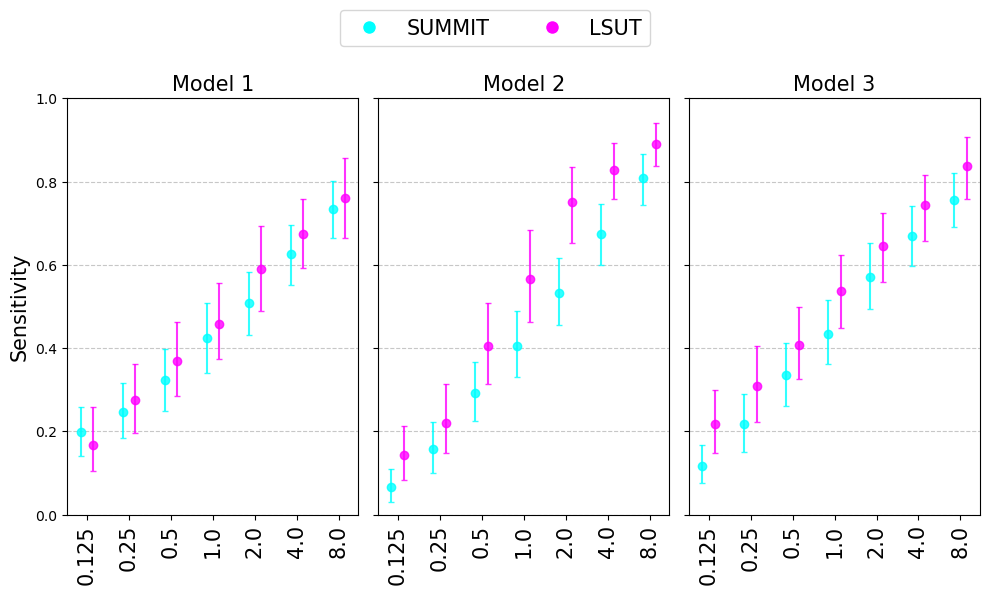

In [36]:
froc_data.head()

bar_width = 0.3
colors = {
    'summit': 'cyan',
    'lsut': 'magenta'
}

model_mappings = {
    'grt123': 'Model 1',
    'detection': 'Model 2',
    'ticnet': 'Model 3'
}

fontsize = 15

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 6), sharey=True)

for ix, model in enumerate(['grt123', 'detection', 'ticnet']):

# for ix, model in enumerate(['detection']):

    df_model = froc_data.query('model == @model and category == "all" and flavour == "test_balanced"')

    for j, dataset in enumerate(['summit', 'lsut']):

        subset = df_model.query('dataset == @dataset')

        # display(subset)

        positions = np.arange(len(subset['fpps'].unique()))
        ax[ix].errorbar(
            positions + j * bar_width,
            subset['mean_sens'],
            yerr=[
                subset['mean_sens'] - subset['low_sens'],
                subset['high_sens'] - subset['mean_sens']
            ],
            fmt='o',
            label=dataset.capitalize(),
            capsize=2,
            alpha=0.8,
            color=colors[dataset]
        )
        ax[ix].set_title(f'{model_mappings[model]}', fontsize=fontsize)
        ax[ix].set_xticks(positions + bar_width / 2)
        ax[ix].set_xticklabels(subset['fpps'].unique(), fontsize=fontsize, rotation=90)
        ax[ix].grid(axis="y", linestyle="--", alpha=0.7)
        ax[ix].set_ylim(0, 1)  # Ensure y-axis runs from 0 to 1

        if ix == 0:
            ax[ix].set_ylabel('Sensitivity', fontsize=fontsize)



legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='SUMMIT', markerfacecolor=colors['summit'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='LSUT', markerfacecolor=colors['lsut'], markersize=10)                        
]


fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=len(legend_elements),
        fontsize=fontsize,
        frameon=True
)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig(f'results/extension/images/dataset_comparison_error_bar_plot.png', bbox_inches='tight')
plt.show()

# Collate all of the CMP data into a single file

In [20]:


cpm_summary_paths = Path('results').rglob('cpm_summary.csv')
cpm_summary_paths = pd.concat([
    (
        pd.read_csv(p)
        .assign(path=p.as_posix())
        .rename(columns={'Unnamed: 0':'category', '0' :'CPM'})
    )
    for p in cpm_summary_paths
])

cpm_summary_paths[['a','dataset','model','flavour','c','d','e']] = cpm_summary_paths.path.str.split('/', expand=True)
cpm_data = cpm_summary_paths.filter(['dataset', 'model','flavour','category','CPM']).query('CPM.notnull()')
cpm_data[['cpm_mean', 'cpm_lower', 'cpm_upper']] = cpm_data['CPM'].str.extract(r'(\d+\.\d+)\s+\(95%\s+CI\s+(\d+\.\d+)-(\d+\.\d+)\)').astype(float)
cpm_data.to_csv('results/cpms.csv', index=False)

cpm_data.query('flavour == "test_balanced" and category == "all"')

,dataset,model,flavour,category,CPM,cpm_mean,cpm_lower,cpm_upper
5,summit,ticnet,test_balanced,all,0.44 (95% CI 0.38-0.51),0.44,0.38,0.51
5,summit,grt123,test_balanced,all,0.44 (95% CI 0.37-0.51),0.44,0.37,0.51
5,summit,detection,test_balanced,all,0.42 (95% CI 0.36-0.49),0.42,0.36,0.49
4,lsut,ticnet,test_balanced,all,0.53 (95% CI 0.44-0.62),0.53,0.44,0.62
4,lsut,grt123,test_balanced,all,0.47 (95% CI 0.39-0.56),0.47,0.39,0.56
4,lsut,detection,test_balanced,all,0.55 (95% CI 0.46-0.63),0.55,0.46,0.63


# Plot CI

********************************************************************************
Dataset: summit
********************************************************************************
Flavour: test_balanced


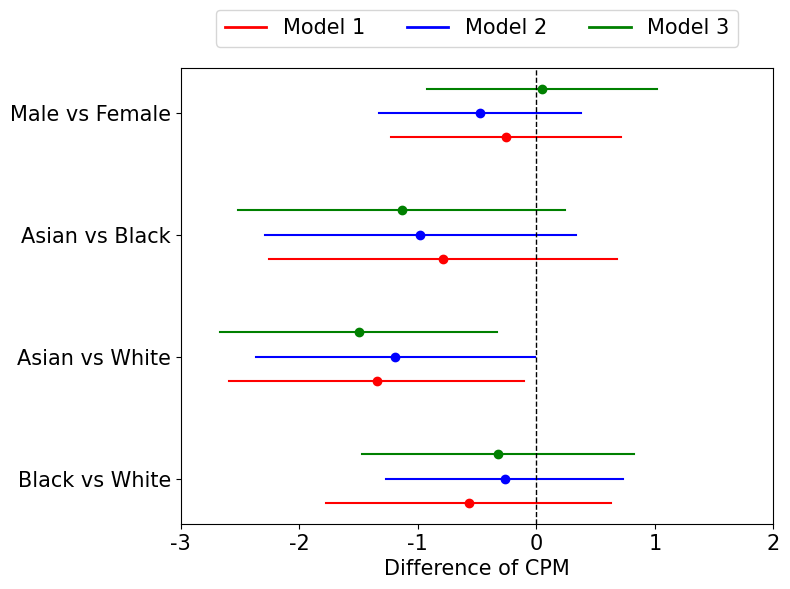

********************************************************************************
Flavour: male_only


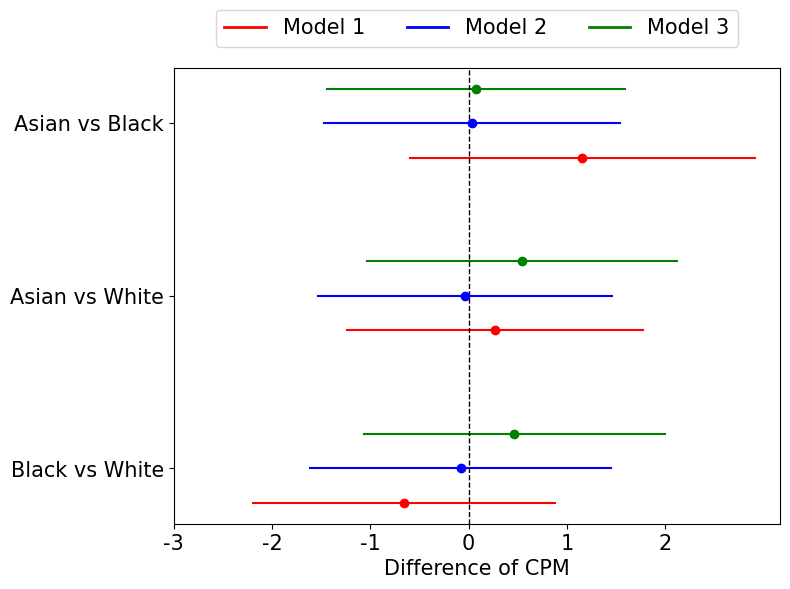

********************************************************************************
Flavour: white_only


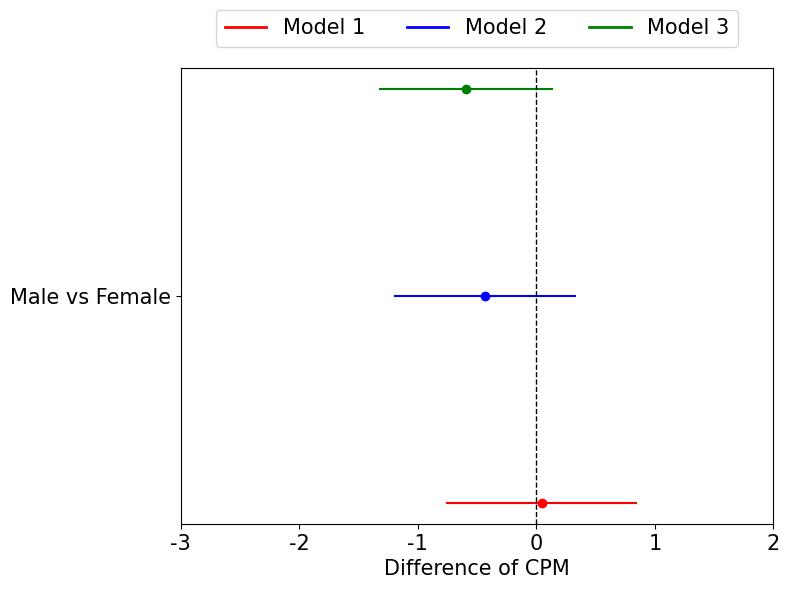

********************************************************************************
Dataset: lsut
********************************************************************************
Flavour: test_balanced


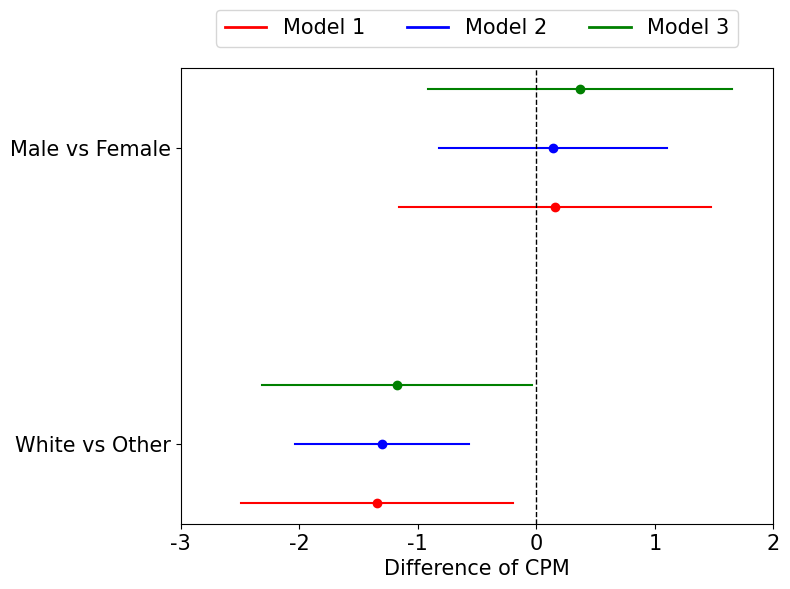

In [113]:

import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

for dataset in ['summit', 'lsut']:

    print('*' * 80)
    print(f"Dataset: {dataset}")

    for flavour in ['test_balanced', 'male_only', 'white_only'] if dataset == 'summit' else ['test_balanced']:

        print('*' * 80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        if dataset == 'summit':        
            mappings = {
                'test_balanced' : {
                    'Black_vs_White': 'Black vs White',
                    'Asian or Asian British_vs_White': 'Asian vs White',
                    'Asian or Asian British_vs_Black': 'Asian vs Black',
                    'MALE_vs_FEMALE': 'Male vs Female'
                },
                'male_only' : {
                    'Black_vs_White': 'Black vs White',
                    'Asian or Asian British_vs_White': 'Asian vs White',
                    'Asian or Asian British_vs_Black': 'Asian vs Black'
                },
                'white_only' : {
                    'MALE_vs_FEMALE': 'Male vs Female'
                },

            }

        else:
            mappings = {
                'test_balanced' : {
                    'White_vs_Other': 'White vs Other',
                    'Male_vs_Female': 'Male vs Female'
                }
            }                

        mappings = mappings[flavour]

        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"').sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"').sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"').sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
            df_grt123.assign(model_name='Model 1', jitter=-0.2, color='red'),
            df_detection.assign(model_name='Model 2', jitter=0, color='blue'),
            df_ticnet.assign(model_name='Model 3', jitter=0.2, color='green')
        ])

        # Create a single plot
        fig, ax = plt.subplots(figsize=(8, 6))
        # Plot data for each category with tighter jitter for each model
        for i, category in enumerate(order):
            subset = combined_df.query('category == @category')

            if subset.shape[0] > 0:
                for _, row in subset.iterrows():
                    adjusted_jitter = row['jitter'] * 0.5 if flavour == 'white_only' else row['jitter']
                    ax.plot(
                    [row['ci_lower'], row['ci_upper']],
                    [i + adjusted_jitter, i + adjusted_jitter],
                    color=row['color'],
                    lw=1.5
                    )
                    ax.scatter(
                    (row['ci_lower'] + row['ci_upper']) / 2,
                    i + adjusted_jitter,
                    color=row['color'],
                    zorder=3
                    )

        # Add a vertical line at x=0
        ax.axvline(x=0, color='black', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order)))
        ax.set_yticklabels([mappings[category] for category in order], fontsize=fontsize)

        # Set x-ticks and labels
        ax.set_xticks([-3, -2, -1, 0, 1, 2])
        ax.set_xticklabels([-3, -2, -1, 0, 1, 2], fontsize=fontsize)

        # Set labels and title
        ax.set_xlabel("Difference of CPM", fontsize=fontsize)
        # ax.set_title(f"{dataset.capitalize()} - {flavour.replace('_', ' ').capitalize()}", fontsize=fontsize)

        # Add legend above the plot
        legend_elements = [
            Line2D([0], [0], color='red', lw=2, label='Model 1'),
            Line2D([0], [0], color='blue', lw=2, label='Model 2'),
            Line2D([0], [0], color='green', lw=2, label='Model 3')
        ]
        ax.legend(handles=legend_elements, fontsize=fontsize, title_fontsize=fontsize, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_jitter_plot.png', bbox_inches='tight')
        plt.show()


********************************************************************************
Dataset: summit
********************************************************************************
Flavour: male_only


,dataset,model,flavour,category,ci_lower,ci_upper
0,summit,detection,male_only,Asian or Asian British_vs_Black,-1.468886,1.542757
1,summit,detection,male_only,Asian or Asian British_vs_White,-1.533922,1.461670
2,summit,detection,male_only,Black_vs_White,-1.610681,1.446396
0,summit,ticnet,male_only,Asian or Asian British_vs_Black,-1.444527,1.588878
1,summit,ticnet,male_only,Asian or Asian British_vs_White,-1.028866,2.117661
2,summit,ticnet,male_only,Black_vs_White,-1.065240,1.991879
0,summit,grt123,male_only,Asian or Asian British_vs_Black,-0.598654,2.909794
1,summit,grt123,male_only,Asian or Asian British_vs_White,-1.236736,1.774036
2,summit,grt123,male_only,Black_vs_White,-2.190456,0.874479


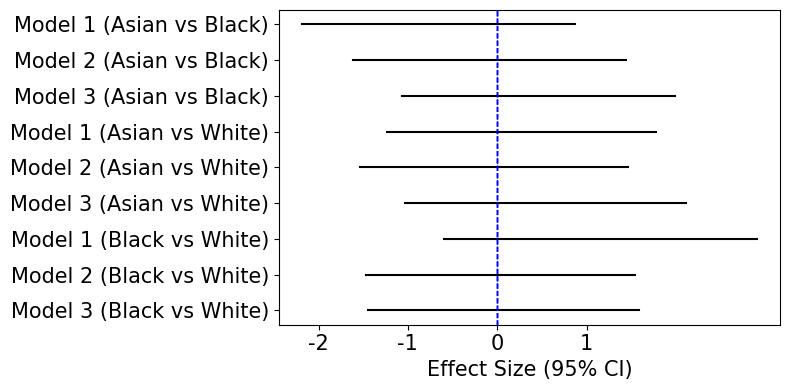

In [49]:
for dataset in ['summit']:

    print('*'*80)
    print(f"Dataset: {dataset}")
    for flavour in ['male_only']:

        print('*'*80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        display(df)

        mappings = {
            'Black_vs_White' : 'Black vs White',
            'Asian or Asian British_vs_White' : 'Asian vs White',
            'Asian or Asian British_vs_Black' : 'Asian vs Black',
        }
        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
                    df_grt123.assign(model_name=lambda df: df['category'] + '_Model 1'),
                    df_detection.assign(model_name=lambda df: df['category'] + '_Model 2'),
                    df_ticnet.assign(model_name=lambda df: df['category'] + '_Model 3')
                ])

        # Create subplots
        fig, ax = plt.subplots(figsize=(8, 4))

        # Plot data for each category
        for i, category in enumerate(['Asian or Asian British_vs_Black', 'Asian or Asian British_vs_White', 'Black_vs_White']):

            subset = combined_df.query('category == @category')


            for _, row in subset.sort_values(by=['model_name'], key=lambda x: x.str.extract(r'Model (\d+)').astype(int)[0], ascending=False).iterrows():
                ax.plot(
                    [
                        row['ci_lower'], 
                        row['ci_upper']
                    ], 
                    [
                        row['model_name'],
                        row['model_name']
                    ],
                    color='black',
                    lw=1.5
                )
            ax.axvline(x=0, color='blue', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order) * 3))
        ytick_labels = [f"{model} ({mappings[category]})" for category in order for model in ['Model 3', 'Model 2', 'Model 1']]
        ax.set_yticklabels(ytick_labels, fontsize=fontsize)  # Reverse the order of labels

        # Set x-ticks and labels
        ax.set_xticks([-2, -1, 0, 1])
        ax.set_xticklabels([-2, -1, 0, 1], fontsize=fontsize)

        ax.set_xlabel("Effect Size (95% CI)", fontsize=fontsize)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_plot.png', bbox_inches='tight')
        plt.show()


********************************************************************************
Dataset: summit
********************************************************************************
Flavour: white_only


,dataset,model,flavour,category,ci_lower,ci_upper
0,summit,detection,white_only,MALE_vs_FEMALE,-1.193388,0.327856
0,summit,grt123,white_only,MALE_vs_FEMALE,-0.749292,0.842081
0,summit,ticnet,white_only,MALE_vs_FEMALE,-1.319189,0.128696


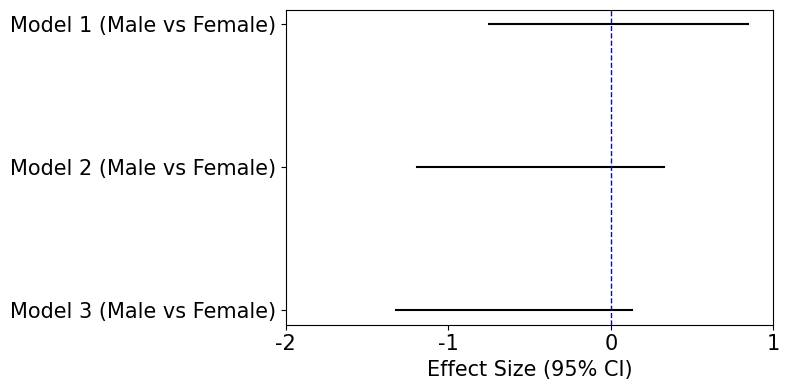

In [48]:

for dataset in ['summit']:

    print('*'*80)
    print(f"Dataset: {dataset}")
    for flavour in ['white_only']:

        print('*'*80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        display(df)

        mappings = {
            'MALE_vs_FEMALE': 'Male vs Female'
        }
        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
                    df_grt123.assign(model_name=lambda df: df['category'] + '_Model 1'),
                    df_detection.assign(model_name=lambda df: df['category'] + '_Model 2'),
                    df_ticnet.assign(model_name=lambda df: df['category'] + '_Model 3')
                ])

        # Create subplots
        fig, ax = plt.subplots(figsize=(8, 4))

        # Plot data for each category
        for i, category in enumerate(['MALE_vs_FEMALE']):

            subset = combined_df.query('category == @category')


            for _, row in subset.sort_values(by=['model_name'], key=lambda x: x.str.extract(r'Model (\d+)').astype(int)[0], ascending=False).iterrows():
                ax.plot(
                    [
                        row['ci_lower'], 
                        row['ci_upper']
                    ], 
                    [
                        row['model_name'],
                        row['model_name']
                    ],
                    color='black',
                    lw=1.5
                )
            ax.axvline(x=0, color='blue', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order) * 3))
        ytick_labels = [f"{model} ({mappings[category]})" for category in order for model in ['Model 3', 'Model 2', 'Model 1']]
        ax.set_yticklabels(ytick_labels, fontsize=fontsize)  # Reverse the order of labels

        # Set x-ticks and labels
        ax.set_xticks([-2, -1, 0, 1])
        ax.set_xticklabels([-2, -1, 0, 1], fontsize=fontsize)

        ax.set_xlabel("Effect Size (95% CI)", fontsize=fontsize)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_plot.png', bbox_inches='tight')
        plt.show()


********************************************************************************
Dataset: lsut
********************************************************************************
Flavour: test_balanced


,dataset,model,flavour,category,ci_lower,ci_upper
0,lsut,grt123,test_balanced,Male_vs_Female,-1.156869,1.471248
1,lsut,grt123,test_balanced,White_vs_Other,-2.487971,-0.197529
0,lsut,ticnet,test_balanced,Male_vs_Female,-0.909627,1.649292
1,lsut,ticnet,test_balanced,White_vs_Other,-2.316280,-0.032468
0,lsut,detection,test_balanced,Male_vs_Female,-0.818486,1.104085
1,lsut,detection,test_balanced,White_vs_Other,-2.036281,-0.563876


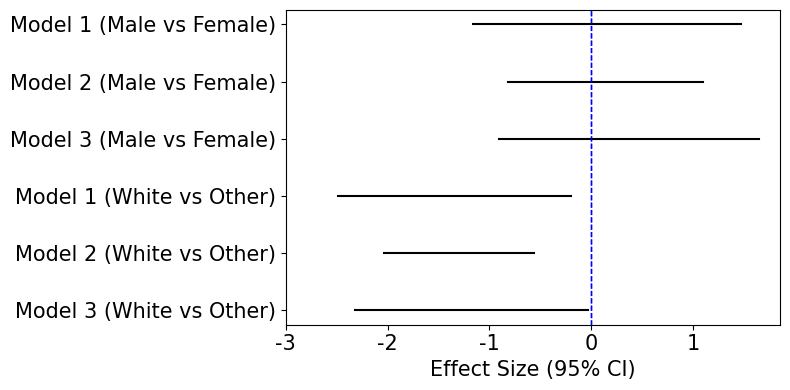

In [39]:

for dataset in ['lsut']:

    print('*'*80)
    print(f"Dataset: {dataset}")
    for flavour in ['test_balanced']:

        print('*'*80)
        print(f"Flavour: {flavour}")

        df = ci_data.query('dataset == @dataset and flavour == @flavour')

        display(df)

        mappings = {
            'White_vs_Other': 'White vs Other',
            'Male_vs_Female': 'Male vs Female'
        }
        # Update order to align with mappings keys
        order = list(mappings.keys())

        # Filter and sort data for each model
        df_detection = df.query('model == "detection"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_grt123 = df.query('model == "grt123"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))
        df_ticnet = df.query('model == "ticnet"') #.sort_values('category', key=lambda x: x.map({k: i for i, k in enumerate(order)}))

        # Combine data for all models
        combined_df = pd.concat([
                    df_grt123.assign(model_name=lambda df: df['category'] + '_Model 1'),
                    df_detection.assign(model_name=lambda df: df['category'] + '_Model 2'),
                    df_ticnet.assign(model_name=lambda df: df['category'] + '_Model 3')
                ])

        # Create subplots
        fig, ax = plt.subplots(figsize=(8, 4))

        # Plot data for each category
        for i, category in enumerate(['White_vs_Other','Male_vs_Female']):

            subset = combined_df.query('category == @category')


            for _, row in subset.sort_values(by=['model_name'], key=lambda x: x.str.extract(r'Model (\d+)').astype(int)[0], ascending=False).iterrows():
                ax.plot(
                    [
                        row['ci_lower'], 
                        row['ci_upper']
                    ], 
                    [
                        row['model_name'],
                        row['model_name']
                    ],
                    color='black',
                    lw=1.5
                )
            ax.axvline(x=0, color='blue', linestyle='--', lw=1)

        # Set y-ticks and labels
        ax.set_yticks(range(len(order) * 3))
        ytick_labels = [f"{model} ({mappings[category]})" for category in order for model in ['Model 3', 'Model 2', 'Model 1']]
        ax.set_yticklabels(ytick_labels, fontsize=fontsize)  # Reverse the order of labels

        # Set x-ticks and labels
        ax.set_xticks([-3, -2, -1, 0, 1])
        ax.set_xticklabels([-3, -2, -1, 0, 1], fontsize=fontsize)

        ax.set_xlabel("Effect Size (95% CI)", fontsize=fontsize)

        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'results/extension/images/{dataset}_{flavour}_ci_combined_plot.png', bbox_inches='tight')
        plt.show()


# Combine mAPs

In [46]:
import json

# Collate the mAP scores
mAP_paths = Path('results').rglob('*mean_mAPs.json')
mAP_paths = pd.concat([
    (
        pd.DataFrame.from_dict(json.load(p.open()), orient='index')
        .reset_index()
        .rename(columns={'index':'category', 0:'mAP'})
        .assign(path=p.as_posix())
    )
    for p in mAP_paths
])

mAP_paths.path.str.split('/', expand=True)

mAP_paths[['d0', 'dataset', 'file_name']] = mAP_paths.path.str.split('/', expand=True)
mAP_paths[['model','p1','p2','iou','d1','d2']] = mAP_paths.file_name.str.split('_', expand=True)
mAP_paths['flavour'] = mAP_paths.p1.str.cat(mAP_paths.p2, sep='_')
mAP_paths['category'] = mAP_paths.category.str.split('_').str[-1]
map_data = mAP_paths.filter(['dataset', 'model','flavour','category','iou', 'mAP'])
# Extract map_mean, lower and upper values
map_data[['map_mean', 'map_lower', 'map_upper']] = map_data['mAP'].str.extract(r'(\d+\.\d+)\s+\(CI\s+95%\s+(\d+\.\d+)-(\d+\.\d+)\)').astype(float)
# Compute error bars (Upper - Mean, Mean - Lower)
map_data["map_error_lower"] = map_data["map_mean"] - map_data["map_lower"]
map_data["map_error_upper"] = map_data["map_upper"] - map_data["map_mean"]

map_data.to_csv('results/mAPs.csv', index=False)
map_data.query('dataset == "lsut" and flavour == "test_balanced" and category not in ["Male","Female", "all"]')[['dataset','model','flavour','category','iou','mAP']].sort_values(['model','category','iou'])

,dataset,model,flavour,category,iou,mAP
3,lsut,detection,test_balanced,Other,0.1,0.24 (CI 95% 0.14-0.36)
4,lsut,detection,test_balanced,Other,0.3,0.24 (CI 95% 0.13-0.35)
0,lsut,detection,test_balanced,Other,0.5,0.2 (CI 95% 0.1-0.32)
4,lsut,detection,test_balanced,White,0.1,0.23 (CI 95% 0.19-0.28)
2,lsut,detection,test_balanced,White,0.3,0.22 (CI 95% 0.18-0.27)
4,lsut,detection,test_balanced,White,0.5,0.18 (CI 95% 0.14-0.23)
2,lsut,grt123,test_balanced,Other,0.1,0.22 (CI 95% 0.13-0.33)
4,lsut,grt123,test_balanced,Other,0.3,0.2 (CI 95% 0.1-0.3)
3,lsut,grt123,test_balanced,Other,0.5,0.12 (CI 95% 0.05-0.2)
4,lsut,grt123,test_balanced,White,0.1,0.23 (CI 95% 0.18-0.27)


# Plot mAP

********************************************************************************
Flavour: test_balanced


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,summit,detection,test_balanced,MALE,0.1,0.11 (CI 95% 0.08-0.14),0.11,0.08,0.14,0.03,0.03
1,summit,detection,test_balanced,Black,0.1,0.1 (CI 95% 0.07-0.14),0.10,0.07,0.14,0.03,0.04
2,summit,detection,test_balanced,FEMALE,0.1,0.15 (CI 95% 0.11-0.19),0.15,0.11,0.19,0.04,0.04
3,summit,detection,test_balanced,White,0.1,0.17 (CI 95% 0.13-0.22),0.17,0.13,0.22,0.04,0.05
4,summit,detection,test_balanced,all,0.1,0.13 (CI 95% 0.1-0.15),0.13,0.10,0.15,0.03,0.02
5,summit,detection,test_balanced,Asian or Asian British,0.1,0.11 (CI 95% 0.07-0.15),0.11,0.07,0.15,0.04,0.04
0,summit,detection,test_balanced,MALE,0.3,0.11 (CI 95% 0.08-0.14),0.11,0.08,0.14,0.03,0.03
1,summit,detection,test_balanced,FEMALE,0.3,0.13 (CI 95% 0.09-0.16),0.13,0.09,0.16,0.04,0.03
2,summit,detection,test_balanced,White,0.3,0.15 (CI 95% 0.11-0.2),0.15,0.11,0.20,0.04,0.05
3,summit,detection,test_balanced,Asian or Asian British,0.3,0.09 (CI 95% 0.06-0.13),0.09,0.06,0.13,0.03,0.04


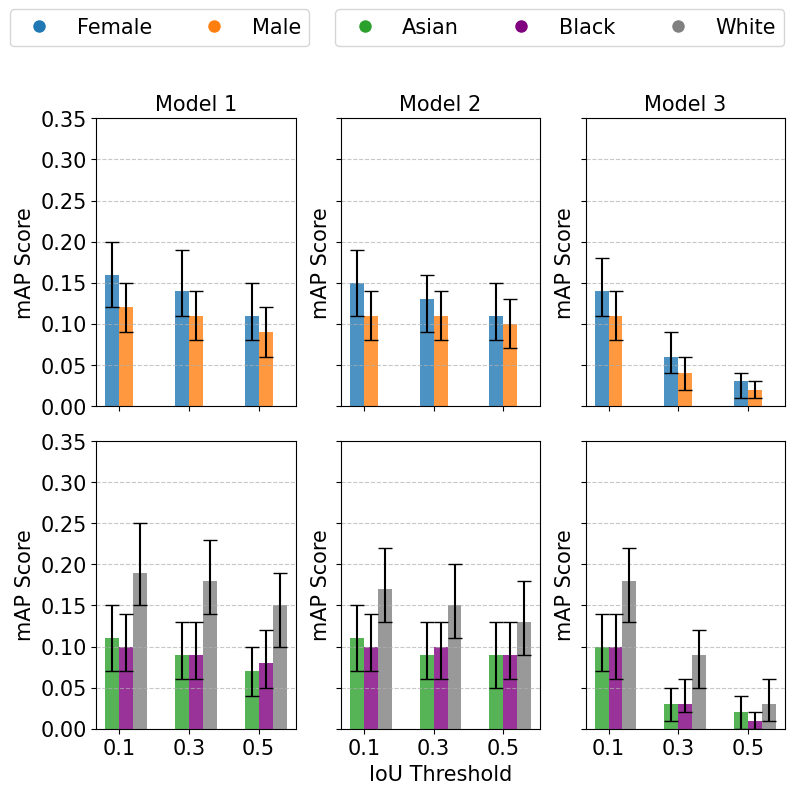

********************************************************************************
Flavour: male_only


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,summit,detection,male_only,all,0.1,0.13 (CI 95% 0.11-0.17),0.13,0.11,0.17,0.02,0.04
1,summit,detection,male_only,Asian or Asian British,0.1,0.11 (CI 95% 0.07-0.16),0.11,0.07,0.16,0.04,0.05
2,summit,detection,male_only,Black,0.1,0.1 (CI 95% 0.06-0.14),0.10,0.06,0.14,0.04,0.04
3,summit,detection,male_only,White,0.1,0.2 (CI 95% 0.14-0.26),0.20,0.14,0.26,0.06,0.06
0,summit,detection,male_only,all,0.3,0.13 (CI 95% 0.1-0.16),0.13,0.10,0.16,0.03,0.03
1,summit,detection,male_only,Asian or Asian British,0.3,0.11 (CI 95% 0.07-0.16),0.11,0.07,0.16,0.04,0.05
2,summit,detection,male_only,Black,0.3,0.1 (CI 95% 0.06-0.14),0.10,0.06,0.14,0.04,0.04
3,summit,detection,male_only,White,0.3,0.19 (CI 95% 0.13-0.25),0.19,0.13,0.25,0.06,0.06
0,summit,detection,male_only,all,0.5,0.11 (CI 95% 0.08-0.14),0.11,0.08,0.14,0.03,0.03
1,summit,detection,male_only,Asian or Asian British,0.5,0.1 (CI 95% 0.06-0.14),0.10,0.06,0.14,0.04,0.04


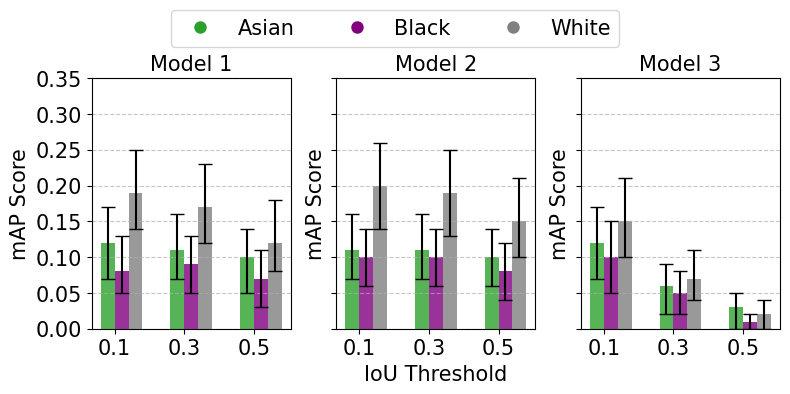

********************************************************************************
Flavour: white_only


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,summit,detection,white_only,all,0.1,0.16 (CI 95% 0.14-0.19),0.16,0.14,0.19,0.02,0.03
1,summit,detection,white_only,MALE,0.1,0.16 (CI 95% 0.12-0.19),0.16,0.12,0.19,0.04,0.03
2,summit,detection,white_only,FEMALE,0.1,0.17 (CI 95% 0.14-0.2),0.17,0.14,0.20,0.03,0.03
0,summit,detection,white_only,all,0.3,0.16 (CI 95% 0.13-0.18),0.16,0.13,0.18,0.03,0.02
1,summit,detection,white_only,MALE,0.3,0.15 (CI 95% 0.12-0.18),0.15,0.12,0.18,0.03,0.03
2,summit,detection,white_only,FEMALE,0.3,0.16 (CI 95% 0.13-0.19),0.16,0.13,0.19,0.03,0.03
0,summit,detection,white_only,all,0.5,0.14 (CI 95% 0.12-0.16),0.14,0.12,0.16,0.02,0.02
1,summit,detection,white_only,MALE,0.5,0.13 (CI 95% 0.11-0.16),0.13,0.11,0.16,0.02,0.03
2,summit,detection,white_only,FEMALE,0.5,0.14 (CI 95% 0.11-0.17),0.14,0.11,0.17,0.03,0.03
0,summit,grt123,white_only,all,0.1,0.18 (CI 95% 0.16-0.21),0.18,0.16,0.21,0.02,0.03


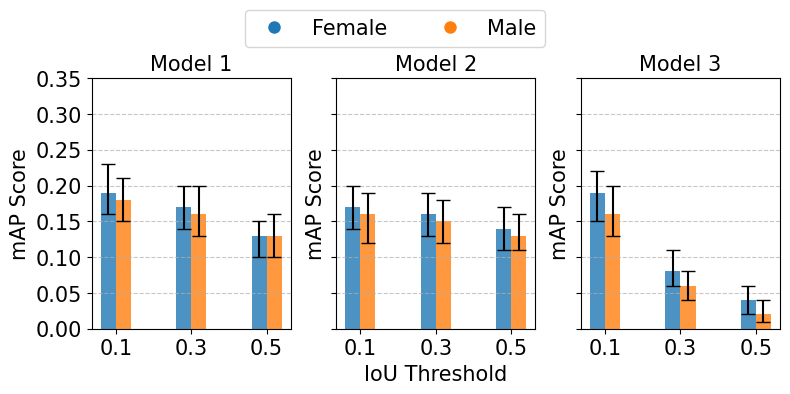

********************************************************************************
Flavour: test_balanced


,dataset,model,flavour,category,iou,mAP,map_mean,map_lower,map_upper,map_error_lower,map_error_upper
0,lsut,detection,test_balanced,Female,0.1,0.27 (CI 95% 0.21-0.35),0.27,0.21,0.35,0.06,0.08
1,lsut,detection,test_balanced,Male,0.1,0.2 (CI 95% 0.15-0.26),0.20,0.15,0.26,0.05,0.06
2,lsut,detection,test_balanced,all,0.1,0.23 (CI 95% 0.19-0.28),0.23,0.19,0.28,0.04,0.05
3,lsut,detection,test_balanced,Other,0.1,0.24 (CI 95% 0.14-0.36),0.24,0.14,0.36,0.10,0.12
4,lsut,detection,test_balanced,White,0.1,0.23 (CI 95% 0.19-0.28),0.23,0.19,0.28,0.04,0.05
0,lsut,detection,test_balanced,all,0.3,0.22 (CI 95% 0.19-0.26),0.22,0.19,0.26,0.03,0.04
1,lsut,detection,test_balanced,Female,0.3,0.26 (CI 95% 0.2-0.33),0.26,0.20,0.33,0.06,0.07
2,lsut,detection,test_balanced,White,0.3,0.22 (CI 95% 0.18-0.27),0.22,0.18,0.27,0.04,0.05
3,lsut,detection,test_balanced,Male,0.3,0.2 (CI 95% 0.14-0.25),0.20,0.14,0.25,0.06,0.05
4,lsut,detection,test_balanced,Other,0.3,0.24 (CI 95% 0.13-0.35),0.24,0.13,0.35,0.11,0.11


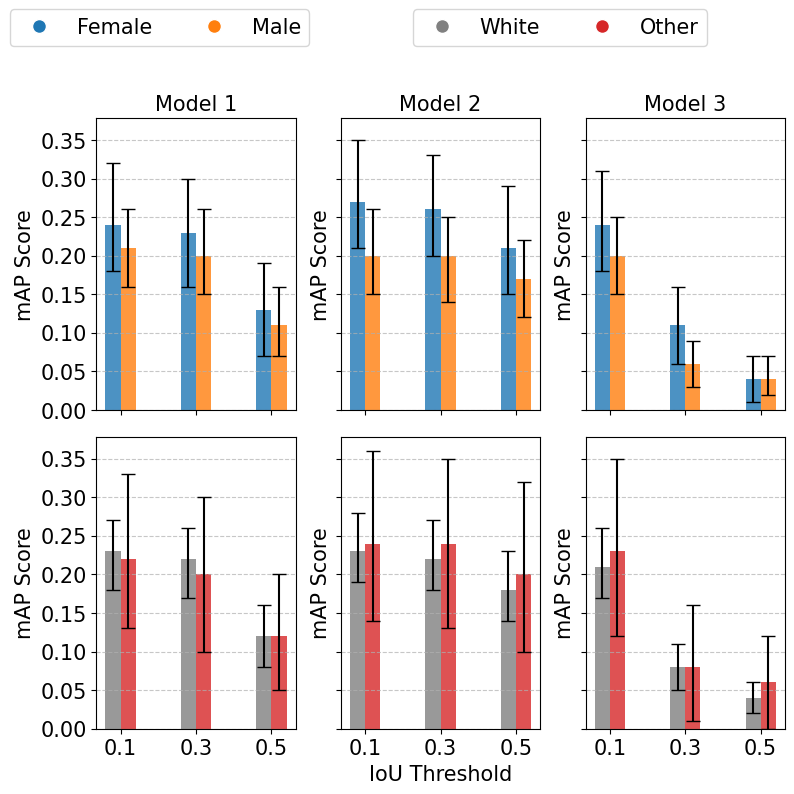

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_maps(dataset, map_data, flavour):
      # Example Data (Replace with your actual dataset)
      df = map_data.query('dataset == @dataset and flavour == @flavour').sort_values(['model','iou'])

      display(df)

      # Set up bar plot
      if flavour == 'male_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 4), sharey=True, sharex=True)
      elif flavour == 'white_only':
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 4), sharey=True, sharex=True)
      else:
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 8), sharey=True, sharex=True)

      # Define positions for bars
      bar_width = 0.2
      categories_top = ['FEMALE', 'MALE' ] if dataset == 'summit' else ['Female', 'Male']
      categories_bottom = ['Asian or Asian British', 'Black', 'White'] if dataset == 'summit' else ['White', 'Other']

      model_mappings = {
            'grt123': 'Model 1',
            'detection': 'Model 2',
            'ticnet': 'Model 3'
      }
      fontsize = 15

      # Define color-blind-friendly palette
      colors = {
            'Female': '#1f77b4',  # Blue
            'Male': '#ff7f0e',    # Orange
            'Asian': '#2ca02c',   # Green
            'Black': 'purple',   # Yellow
            'White': 'grey',   # Grey
            'Other': '#d62728'    # Red
      }

      # Plot bars for each model and category
      for i, model in enumerate(['grt123', 'detection', 'ticnet']):
            df_model = df.query('model == @model')

            if flavour != 'male_only':
                    # Top row plots
                    ax_top = axes[0, i] if flavour != 'white_only' else axes[i]
                    for j, category in enumerate(categories_top):
                              subset = df_model.query('category == @category')
                              positions = np.arange(len(subset['iou'].unique()))
                              ax_top.bar(
                                      positions + j * bar_width, 
                                      subset['map_mean'], 
                                      width=bar_width,
                                      yerr=[
                                                subset['map_error_lower'],
                                                subset['map_error_upper']
                                      ],
                                      capsize=5,
                                      label=category.replace('FEMALE','Female').replace('MALE','Male'),
                                      color=colors[category.replace('FEMALE','Female').replace('MALE','Male')],
                                      alpha=0.8
                              )
                              
                    ax_top.set_title(f'{model_mappings[model]}', fontsize=fontsize)
                    ax_top.set_xticks(positions + bar_width / 2)
                    ax_top.set_xticklabels(subset['iou'].unique(), fontsize=fontsize)

                    if flavour == 'white_only' and i == 1:
                              ax_top.set_xlabel("IoU Threshold", fontsize=fontsize)
   
                    ax_top.set_ylabel("mAP Score", fontsize=fontsize)
                    ax_top.set_yticks(np.arange(0, 0.36, 0.05))
                    ax_top.tick_params(axis='y', labelsize=fontsize)

                    ax_top.grid(axis="y", linestyle="--", alpha=0.7)


            if flavour != 'white_only':
                    # Bottom row plots
                    ax_bottom = axes[1, i] if flavour != 'male_only' else axes[i]
                    for j, category in enumerate(categories_bottom):
                              subset = df_model.query('category == @category')
                              positions = np.arange(len(subset['iou'].unique()))
                              ax_bottom.bar(
                                      positions + j * bar_width,
                                      subset['map_mean'],
                                      width=bar_width,
                                      yerr=[
                                                subset['map_error_lower'],
                                                subset['map_error_upper']
                                      ],
                                      capsize=5,
                                      label=category.replace('Asian or Asian British', 'Asian'),
                                      color=colors[category.replace('Asian or Asian British', 'Asian')],
                                      alpha=0.8
                              )
                    ax_bottom.set_xticks(positions + bar_width / 2)
                    ax_bottom.set_xticklabels(subset['iou'].unique(), fontsize=fontsize)

                    if flavour == 'male_only':
                              ax_bottom.set_title(f'{model_mappings[model]}', fontsize=fontsize)                  
                        
                    ax_bottom.set_ylabel("mAP Score", fontsize=fontsize)
                    ax_bottom.set_yticks(np.arange(0, 0.36, 0.05))
                    ax_bottom.tick_params(axis='y', labelsize=fontsize)

                    if i == 1:
                              ax_bottom.set_xlabel("IoU Threshold", fontsize=fontsize)

                    ax_bottom.grid(axis="y", linestyle="--", alpha=0.7)

    # Create legends for sex and ethnic group
      if flavour in ['test_balanced', 'white_only']:
            legend_elements_sex = [
                  Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=colors['Female'], markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=colors['Male'], markersize=10)
            ]
            

      if flavour in ['test_balanced', 'male_only']:
            if dataset == 'summit':
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='Asian', markerfacecolor=colors['Asian'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Black', markerfacecolor=colors['Black'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10)
                  ]
            else:
                  legend_elements_ethnic = [
                        Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor=colors['Other'], markersize=10)                        
                  ]


      if flavour == "test_balanced":
            fig.legend(
                    handles=legend_elements_sex,
                    loc='upper center',
                    ncol=len(legend_elements_sex),
                    bbox_to_anchor=(0.20, 1),
                    fontsize=fontsize,
                    frameon=True
            )

            fig.legend(
                    handles=legend_elements_ethnic,
                    loc='upper center',
                    ncol=len(legend_elements_ethnic),
                    bbox_to_anchor=(0.70, 1),
                    fontsize=fontsize,
                    frameon=True
            )

      elif flavour == 'white_only':
            fig.legend(handles=legend_elements_sex, loc='upper center', ncol=2, fontsize=fontsize, frameon=True)
      
      elif flavour == 'male_only':
            fig.legend(handles=legend_elements_ethnic, loc='upper center', ncol=3, fontsize=fontsize, frameon=True)


      # Adjust layout to make space for the legend and suptitle
      if flavour in ['male_only', 'white_only']:
            plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave more space at the top
      else:
            plt.tight_layout(rect=[0, 0, 1, 0.90])

      plt.savefig(f'results/extension/images/{dataset}_{flavour}_mAP_plot.png', bbox_inches='tight')            
      plt.show()

for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_maps('summit', map_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_maps('lsut', map_data, flavour)

Dataset: summit, Model: detection, Flavour: male_only
Dataset: summit, Model: grt123, Flavour: male_only
Dataset: summit, Model: detection, Flavour: white_only
Dataset: summit, Model: ticnet, Flavour: test_balanced
Dataset: summit, Model: ticnet, Flavour: male_only
Dataset: summit, Model: grt123, Flavour: white_only
Dataset: summit, Model: grt123, Flavour: test_balanced
Dataset: summit, Model: detection, Flavour: test_balanced
Dataset: summit, Model: ticnet, Flavour: white_only
Dataset: lsut, Model: ticnet, Flavour: test_balanced
Dataset: lsut, Model: grt123, Flavour: test_balanced
Dataset: lsut, Model: detection, Flavour: test_balanced
********************************************************************************
Flavour: test_balanced


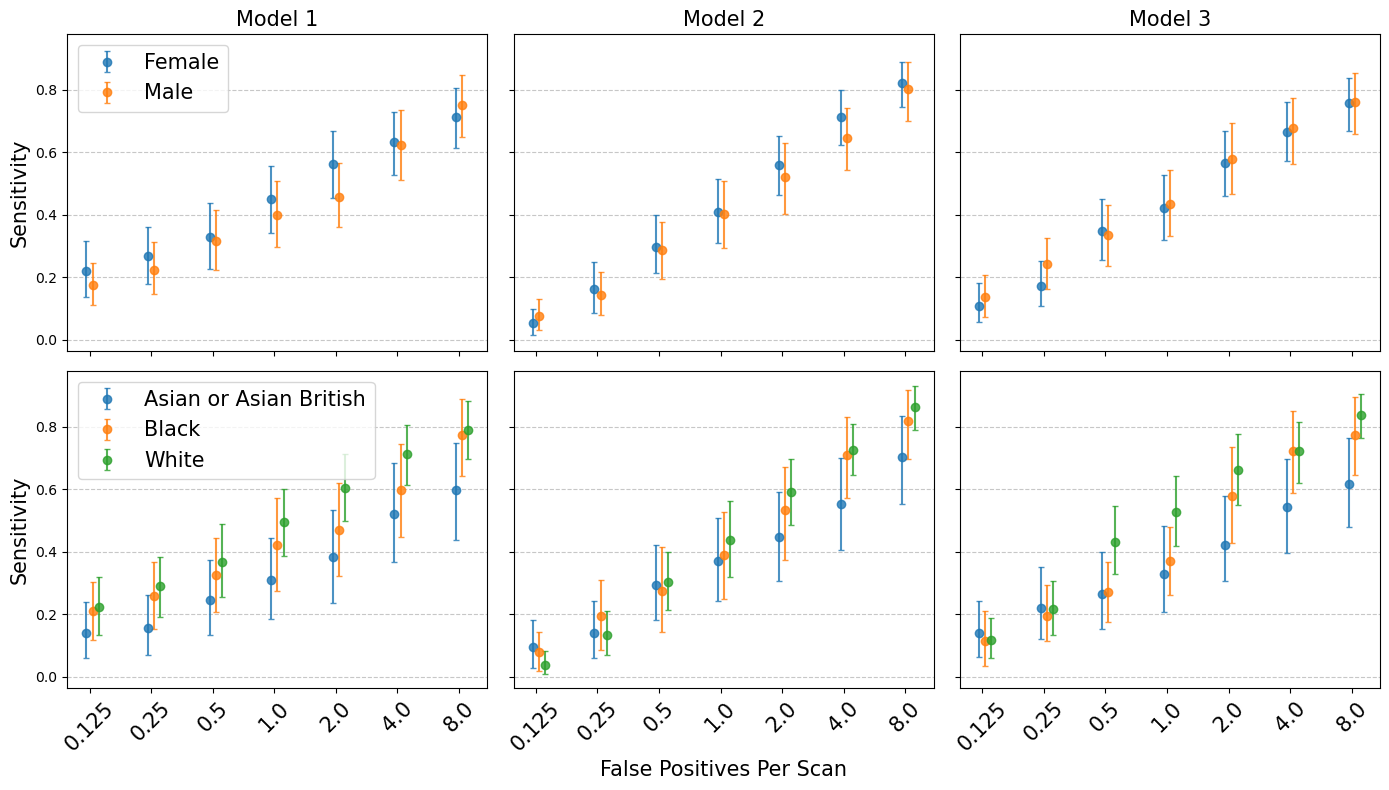

********************************************************************************
Flavour: male_only


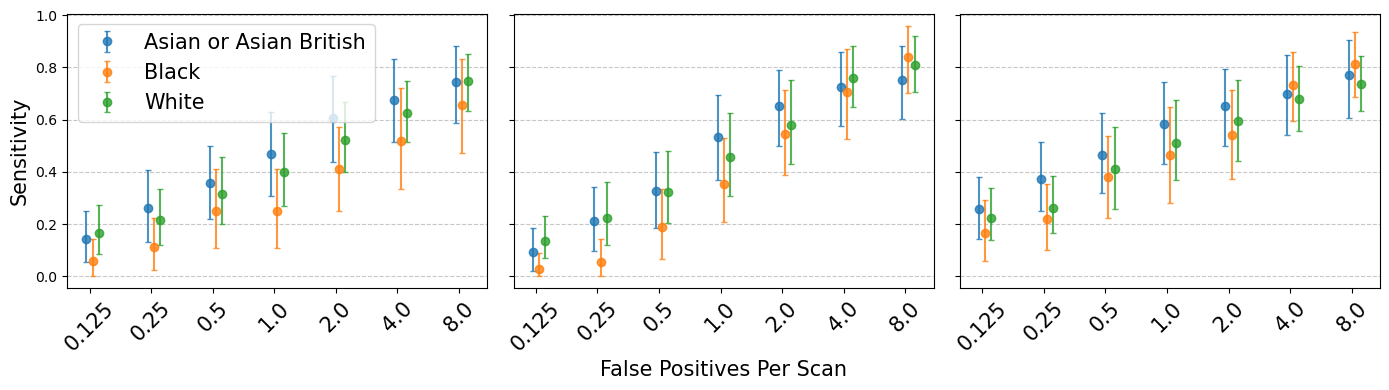

********************************************************************************
Flavour: white_only


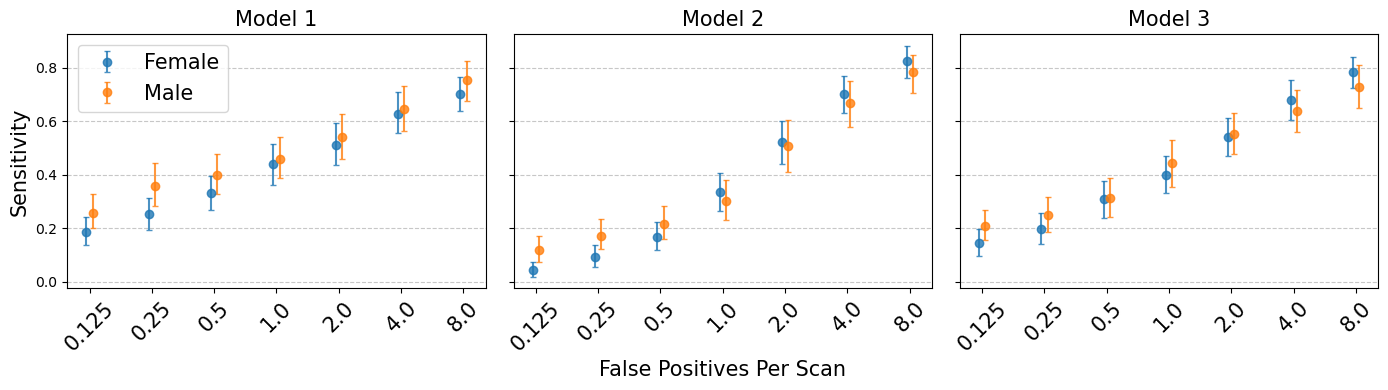

********************************************************************************
Flavour: test_balanced


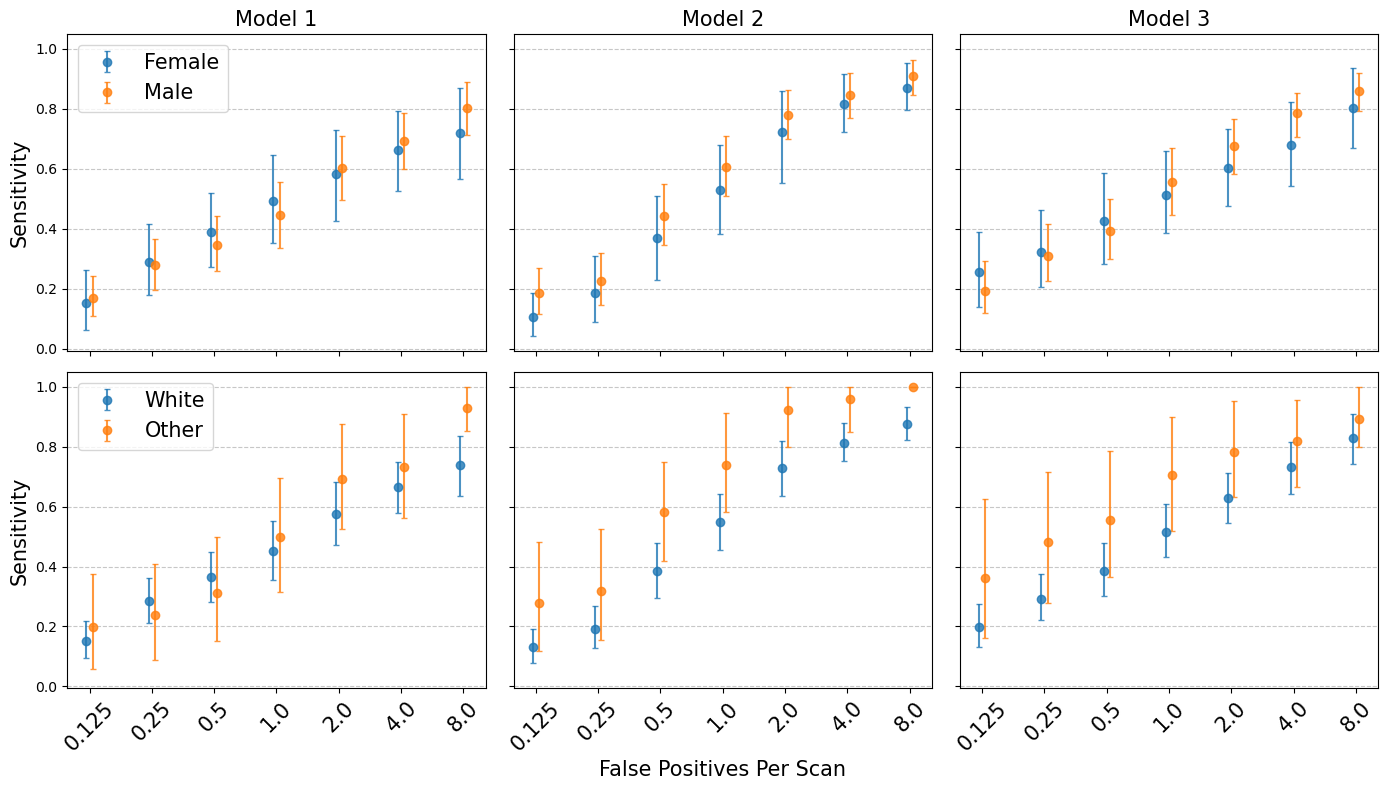

In [87]:
# Combine fixed froc data
from pathlib import Path
import json

p = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/workflows/FairnessInNoduleDetectionAlgorithms/results/summit/detection_test_balanced_froc_fixed_thresholds.json')
json_data = json.load(p.open())

fpps_recode = {0 : 0.125, 1 : 0.25, 2 : 0.5, 3 : 1, 4 : 2, 5 : 4, 6 : 8}

data_list = []

for path in Path('results').rglob('*_froc_fixed_thresholds.json'):

    path_parts = path.parts
    dataset = path_parts[-2]
    filename = path.stem
    model = filename.split('_')[0]
    flavour = '_'.join(filename.split('_')[1:3])

    print(f"Dataset: {dataset}, Model: {model}, Flavour: {flavour}")

    json_data = json.load(path.open())

    for category, data in json_data.items():
        data_list.append(
            pd.DataFrame.from_dict(data, orient='index')
            .rename(columns={'mean_sens':'mean_sens', 'lower_sens':'low_sens', 'upper_sens':'high_sens'})
            .reset_index().rename(columns={'index':'threshold'})
            .reset_index().rename(columns={'index':'fpps'})
            .assign(fpps=lambda df: df['fpps'].map(fpps_recode))
            .assign(category=category)
            .assign(dataset=dataset)
            .assign(model=model)
            .assign(flavour=flavour)
        )

froc_data = pd.concat(data_list)
froc_data.query('dataset == "summit" and flavour == "test_balanced" and category == "Black" and fpps == 0.125')


for flavour in ['test_balanced', 'male_only', 'white_only']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('summit', froc_data, flavour)

for flavour in ['test_balanced']:
      print('*'*80)
      print(f"Flavour: {flavour}")
      plot_frocs('lsut', froc_data, flavour)


# Combine the nodule characteristics images

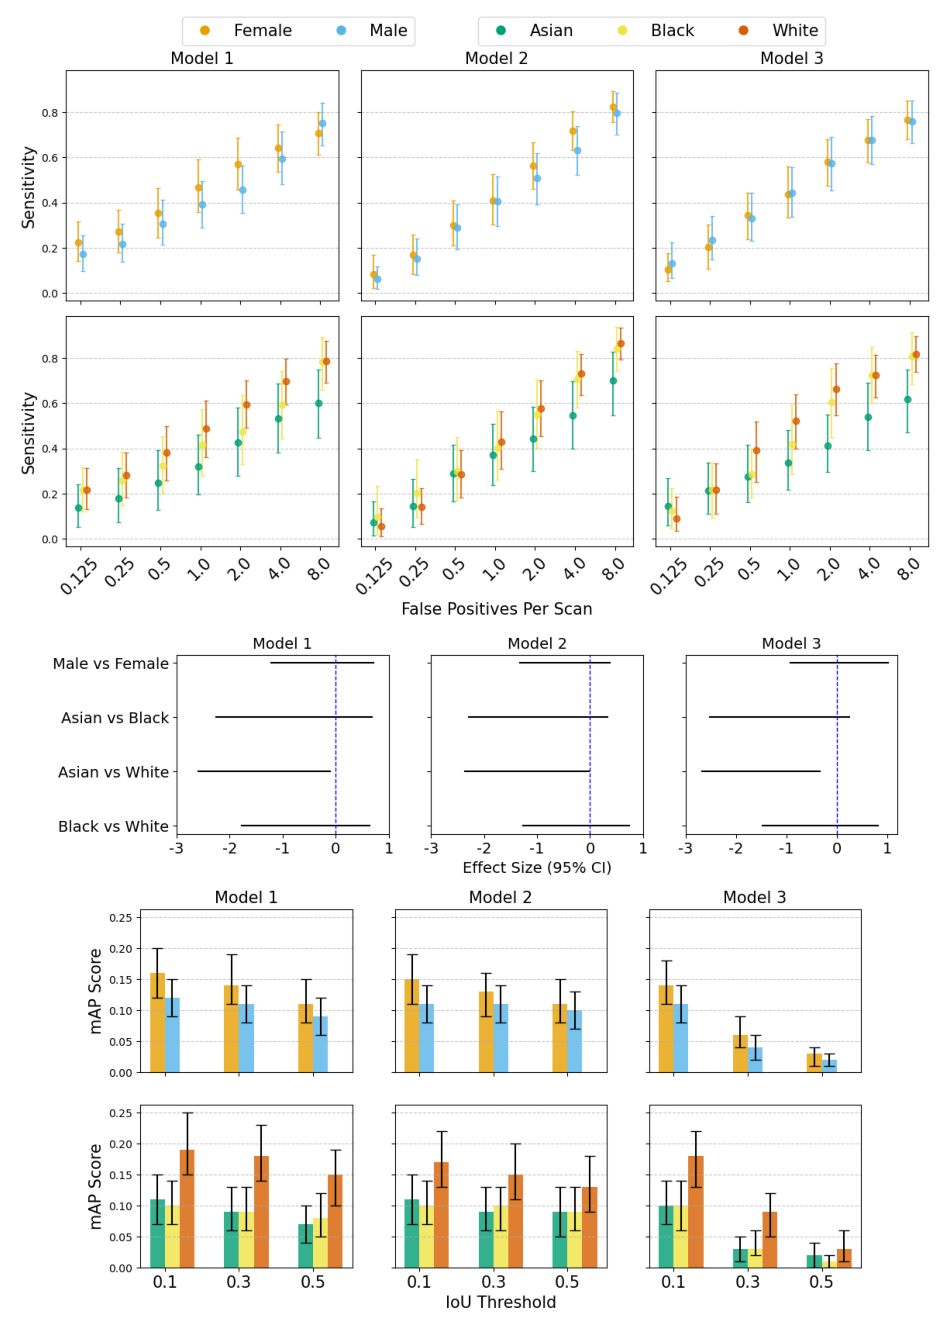

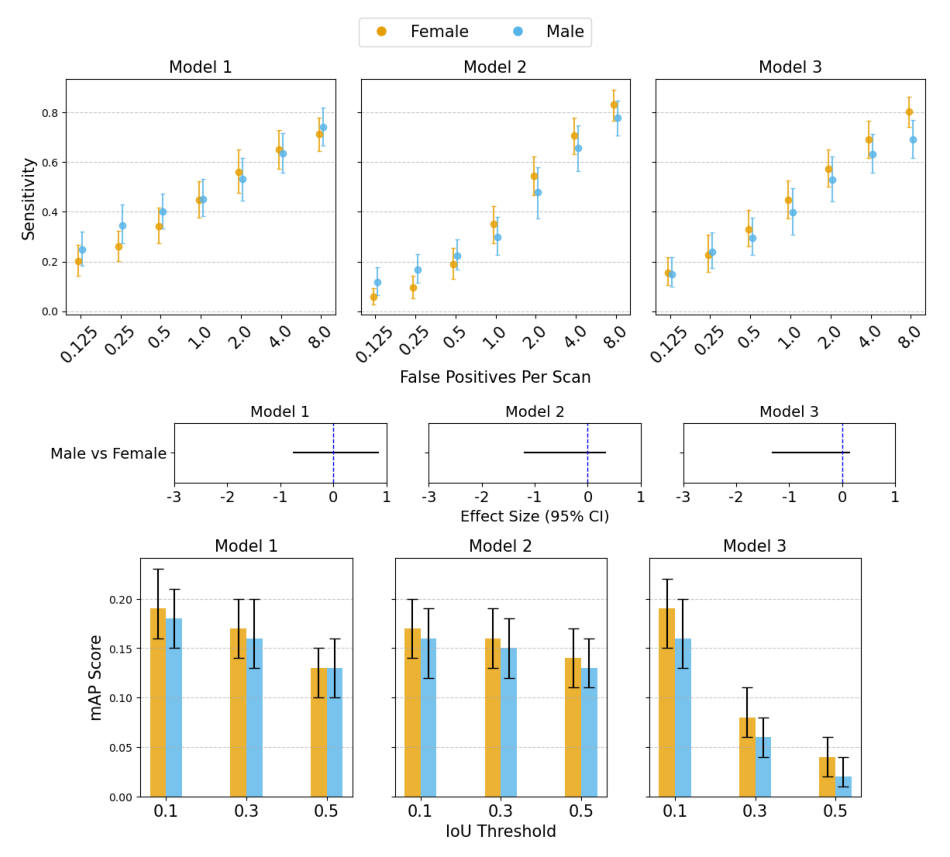

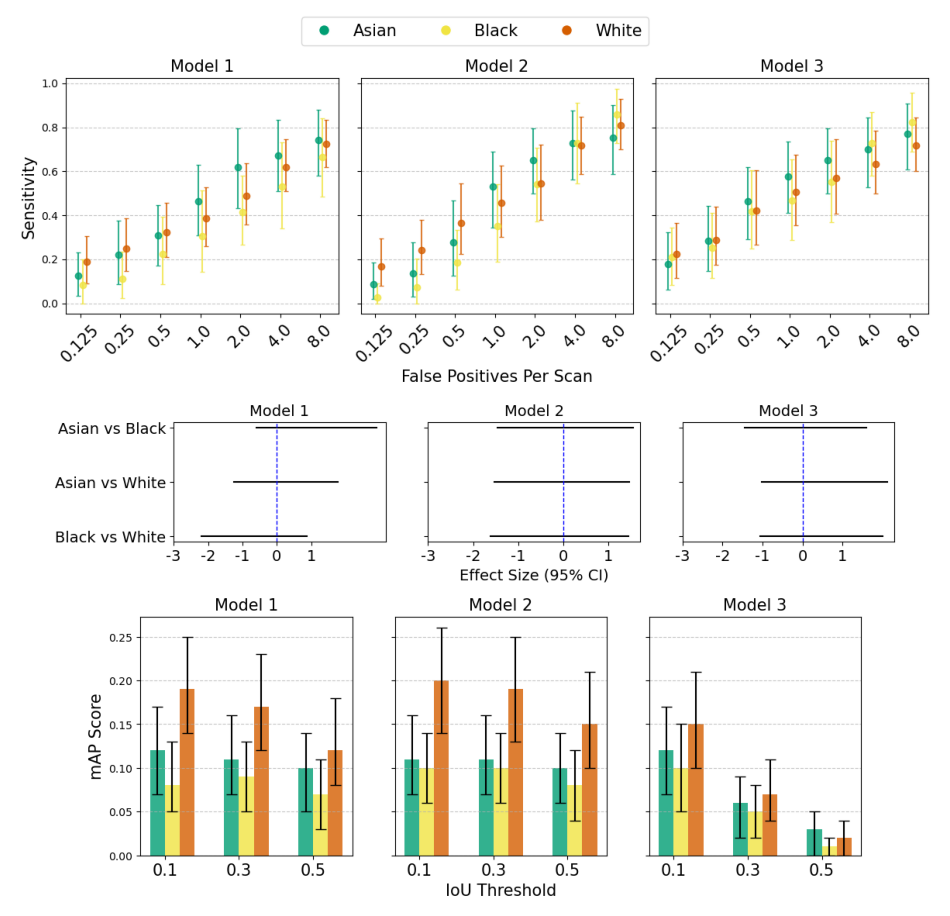

In [123]:
from PIL import Image
import matplotlib.pyplot as plt

dataset = "summit"
for flavour in ['test_balanced', 'white_only', 'male_only']:
    # Load the images
    error_bar_plot = Image.open(f'results/extension/images/{dataset}_{flavour}_error_bar_plot.png')
    ci_plot = Image.open(f'results/extension/images/{dataset}_{flavour}_ci_plot.png')
    mAP_plot = Image.open(f'results/extension/images/{dataset}_{flavour}_mAP_plot.png')

    # Get the dimensions of the images
    width1, height1 = error_bar_plot.size
    width2, height2 = ci_plot.size
    width3, height3 = mAP_plot.size


    padding = 0

    # Centralise and white fill extra space for ci_plot
    if width2 < max(width1, width3):
        new_ci_plot = Image.new("RGBA", (max(width1, width3), height2 + padding), "white")
        new_ci_plot.paste(ci_plot, ((max(width1, width3) - width2) // 2, 0))
        ci_plot = new_ci_plot

    # Centralise and white fill extra space for mAP_plot
    if width3 < max(width1, width2):
        new_mAP_plot = Image.new("RGBA", (max(width1, width2), height3 + padding), "white")
        new_mAP_plot.paste(mAP_plot, ((max(width1, width2) - width3) // 2, 0))
        mAP_plot = new_mAP_plot

    # Create a new image with a size that can fit all three images vertically
    combined_width = max(width1, width2, width3)
    combined_height = height1 + (height2 + padding) + (height3 + padding)
    combined_img = Image.new("RGB", (combined_width, combined_height), "white")

    # Paste the images into the combined image
    combined_img.paste(error_bar_plot, (0, 0))
    combined_img.paste(ci_plot, (0, height1))
    combined_img.paste(mAP_plot, (0, height1 + (height2 + padding)))

    # Save the combined image
    combined_img.save(f'results/extension/images/{dataset}_{flavour}_combined_plot.png')

    # Display the combined image using matplotlib
    fig, ax = plt.subplots(figsize=(12, 18))
    ax.imshow(combined_img)
    ax.axis('off')  # Hide the axis
    plt.show()

# Nodule Characteristics

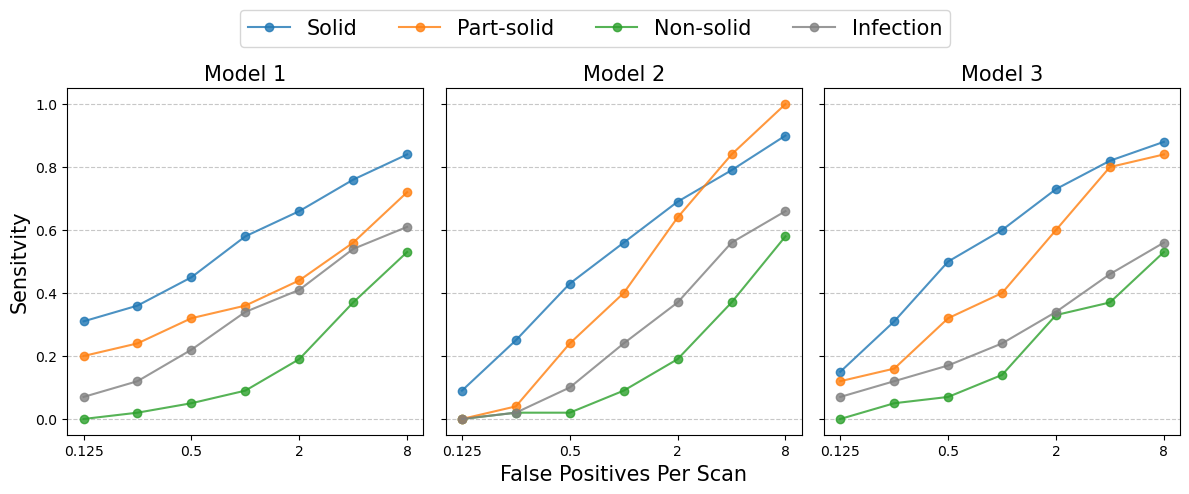

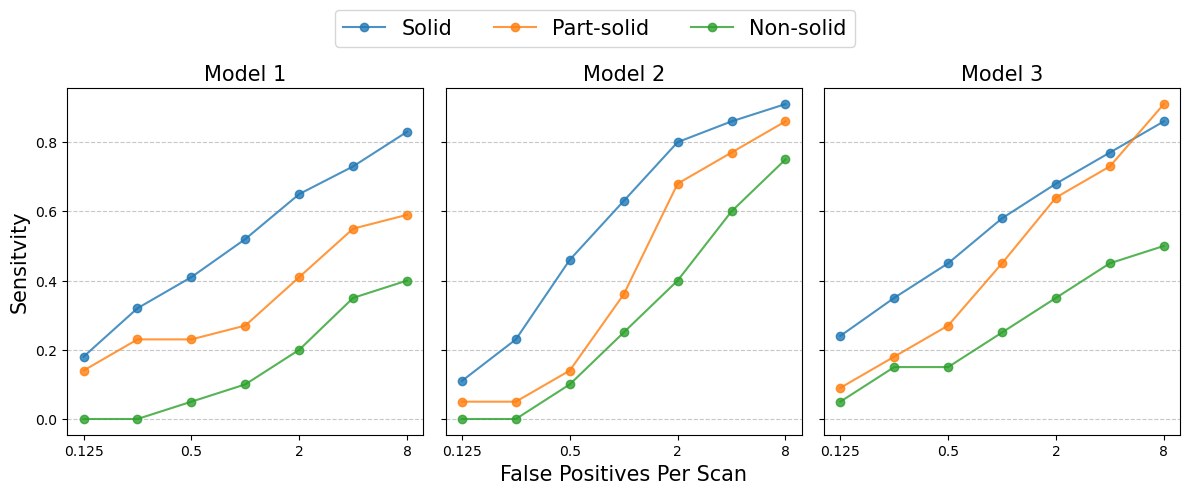

In [ ]:

from pathlib import Path
from tkinter.tix import InputOnly
import pandas as pd

for dataset in ['summit','lsut']:

 

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(f'results/extension/images/{dataset}_nodule_type_froc_plot.png', bbox_inches='tight')



/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_83101/2579228343.py:140: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1], axes[0, 2])
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_83101/2579228343.py:143: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes[1, 0].get_shared_y_axes().join(axes[1, 0], axes[1, 1], axes[1, 2])
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_83101/2579228343.py:140: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1], axes[0, 2])
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_83101/2579228343.py:143: MatplotlibDeprecationWarning: The join function was deprecate

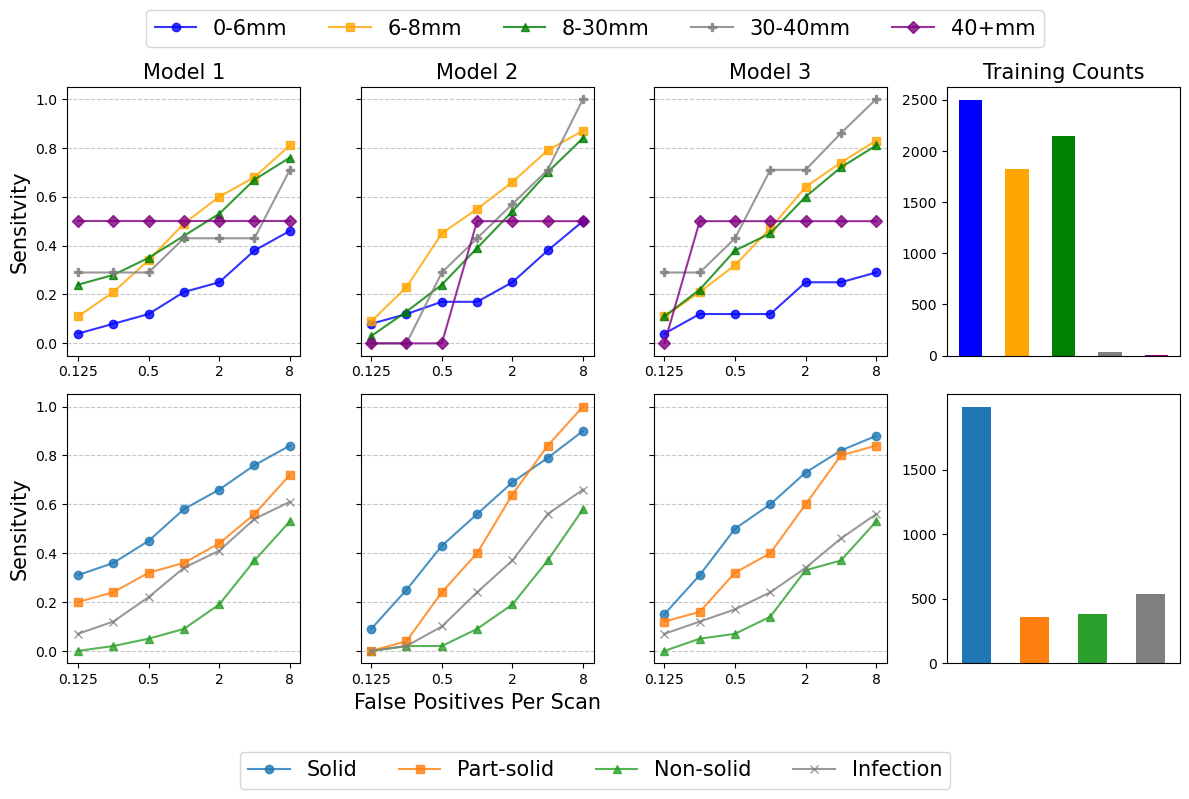

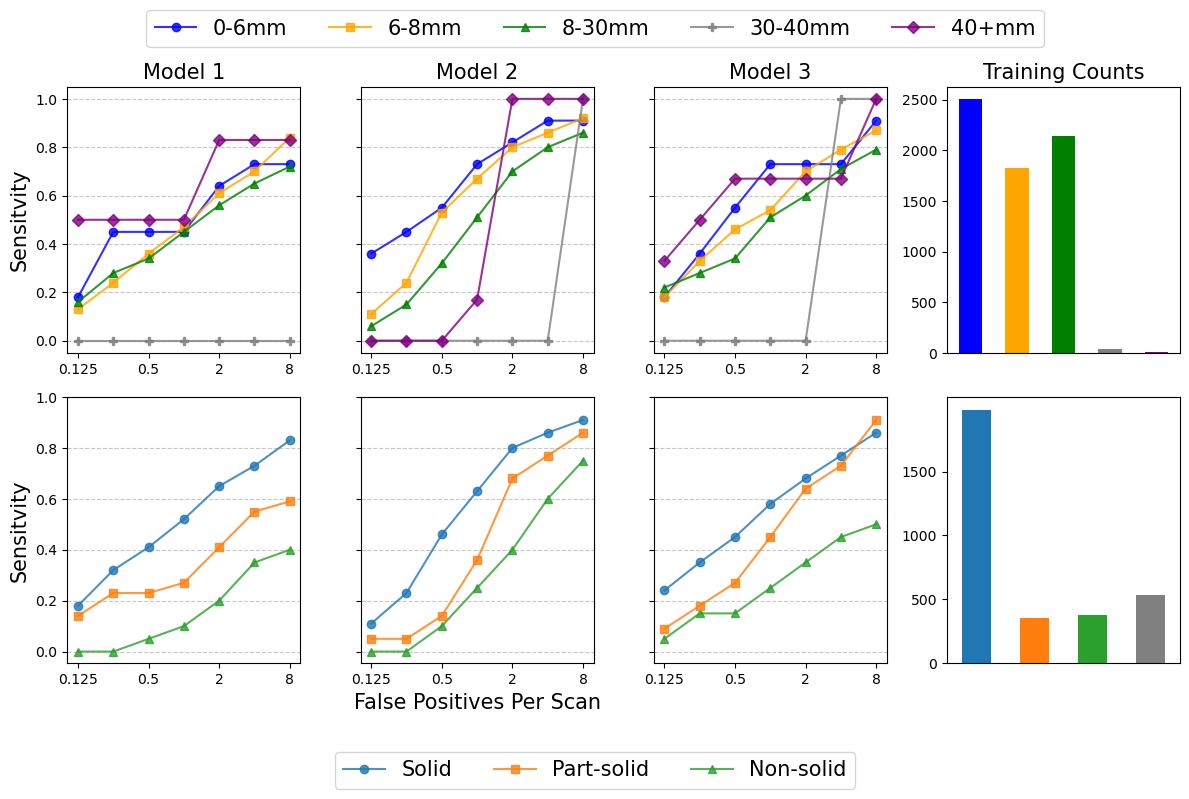

In [302]:
from pathlib import Path
from tkinter.tix import InputOnly
from networkx import diameter
import pandas as pd

diameter_cats = [0, 6, 8, 30, 40, 999]

diameter_lbs = [
    '0-6mm',
    '6-8mm',
    '8-30mm',
    '30-40mm',
    '40+mm'
] 

diameter_colors = {
    '0-6mm' : 'blue', 
    '6-8mm' : 'orange', 
    '8-30mm' : 'green', 
    '30-40mm' : 'grey', 
    '40+mm' : 'purple'
}

diameter_mappings = {
    '0-6mm' : '0-6mm', 
    '6-8mm' : '6-8mm', 
    '8-30mm' : '8-30mm', 
    '30-40mm' : '30-40mm', 
    '40+mm' : '40+mm'
}

diameter_markings = {
    '0-6mm' : 'o',       # Circle
    '6-8mm' : 's',       # Square
    '8-30mm' : '^',      # Triangle
    '30-40mm' : 'P',     # Plus
    '40+mm' : 'D'        # Diamond
}

nodule_colors = {
    'SOLID' : '#1f77b4',  # Blue
    'PART_SOLID' : '#ff7f0e',    # Orange
    'NON_SOLID' : '#2ca02c',   # Green
    'CALCIFIED' : 'grey',    # Purple
}

nodule__mappings = {
    'SOLID' : 'Solid',
    'PART_SOLID' : 'Part-Solid',
    'NON_SOLID' : 'Non-Solid',
    'CALCIFIED' : 'Infection'
}

nodule_markings = {
    'SOLID' : 'o', 
    'PART_SOLID' : 's', 
    'NON_SOLID' : '^', 
    'CALCIFIED' : 'x'
}

for dataset in ['summit','lsut']:

    diameter_data = (
        pd.concat([
            pd.read_csv(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/diameter_cats_nodule_characteristics.csv').assign(model='grt123'),
            pd.read_csv(f'results/{dataset}/detection/test_balanced/Actionable/FROC/diameter_cats_nodule_characteristics.csv').assign(model='detection'),
            pd.read_csv(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/diameter_cats_nodule_characteristics.csv').assign(model='ticnet')
        ])
        .assign(dataset=dataset)
    )

    nodule_type_data = (
        pd.concat([
            pd.read_csv(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/nodule_type_nodule_characteristics.csv').assign(model='grt123'),
            pd.read_csv(f'results/{dataset}/detection/test_balanced/Actionable/FROC/nodule_type_nodule_characteristics.csv').assign(model='detection'),
            pd.read_csv(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/nodule_type_nodule_characteristics.csv').assign(model='ticnet')
        ])
        .assign(dataset=dataset)
    )

    if dataset == 'lsut':
        nodule_type_data = nodule_type_data.query('nodule_type != "CALCIFIED"')

    # Generate the plot
    fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12, 8))

 
    for ix, model in enumerate(['grt123', 'detection', 'ticnet']):

        subset = diameter_data.query('model == @model')
        subset = subset.set_index('diameter_cats').filter(['0.125', '0.25', '0.5', '1', '2', '4', '8'])

        subset.T.plot(
            ax=axes[0, ix], 
            marker='o',  # Default marker
            linestyle='-', 
            alpha=0.8, 
            color=[diameter_colors[diameter_cat] for diameter_cat in subset.index], 
            label=[diameter_mappings[diameter_cat] for diameter_cat in subset.index]
        )

        for line, diameter_cat in zip(axes[0, ix].get_lines(), subset.index):
            line.set_marker(diameter_markings[diameter_cat])  # Update marker for each line
        
        axes[0, ix].set_title(f'{model_mappings[model]}', fontsize=fontsize)

        if ix == 0:
            axes[0, ix].set_ylabel('Sensitvity', fontsize=fontsize)

        axes[0, ix].grid(axis="y", linestyle="--", alpha=0.7)
        axes[0, ix].set_yticks([i * 0.2 for i in range(6)])  # Set yticks from 0 to 1 in 0.2 increments
        axes[0, ix].legend().remove()  # Remove in-axis legend

        subset = nodule_type_data.query('model == @model')
        subset = subset.set_index('nodule_type').filter(['0.125', '0.25', '0.5', '1', '2', '4', '8'])

        subset.T.plot(
            ax=axes[1, ix], 
            marker='o', 
            linestyle='-', 
            alpha=0.8, 
            color=[nodule_colors[nodule_type] for nodule_type in subset.index], 
            label=[nodule__mappings[nodule_type] for nodule_type in subset.index]
        )

        for line, nodule_type in zip(axes[1, ix].get_lines(), subset.index):
            line.set_marker(nodule_markings[nodule_type])  # Update marker for each line

        if ix == 1:
            axes[1, ix].set_xlabel('False Positives Per Scan', fontsize=fontsize)

        if ix == 0:
            axes[1, ix].set_ylabel('Sensitvity', fontsize=fontsize)

        axes[1, ix].grid(axis="y", linestyle="--", alpha=0.7)
        axes[1, ix].set_yticks([i * 0.2 for i in range(6)])  # Set yticks from 0 to 1 in 0.2 increments
        axes[1, ix].legend().remove()  # Remove in-axis legend

        # Set shared y-axis for the top row
        axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1], axes[0, 2])

        # Set shared y-axis for the bottom row
        axes[1, 0].get_shared_y_axes().join(axes[1, 0], axes[1, 1], axes[1, 2])

    # Add a single legend above all plots
    nodule_handles, nodule_labels = axes[1,0].get_legend_handles_labels()
    # Reverse the order of handles and labels to match the desired order
    nodule_reversed_order = ['SOLID', 'PART_SOLID', 'NON_SOLID', 'CALCIFIED'] if dataset == 'summit' else ['SOLID', 'PART_SOLID', 'NON_SOLID']
    nodule_handles = [nodule_handles[nodule_labels.index(category)] for category in nodule_reversed_order]
    nodule_labels = nodule_reversed_order

    # Add a single legend above all plots
    diameter_handles, diameter_labels = axes[0,0].get_legend_handles_labels()
    # Reverse the order of handles and labels to match the desired order
    diameter_reversed_order = ['0-6mm', '6-8mm', '8-30mm', '30-40mm', '40+mm']
    diameter_handles = [diameter_handles[diameter_labels.index(category)] for category in diameter_reversed_order]
    diameter_labels = diameter_reversed_order

    fig.legend(
        diameter_handles, 
        diameter_labels,
        loc='upper center',
        ncol=len(diameter_labels),
        fontsize=fontsize,
        frameon=True
    )

    fig.legend(
        nodule_handles, 
        ['Solid', 'Part-solid', 'Non-solid', 'Infection'] if dataset == 'summit' else ['Solid', 'Part-solid', 'Non-solid'],
        loc='lower center',
        ncol=len(nodule_labels),
        fontsize=fontsize,
        frameon=True
    )

    training_nodule_vc = (
        pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_type'])
        .query('nodule_type in ["SOLID","PART_SOLID","NON_SOLID","CALCIFIED"]')['nodule_type']
        .value_counts()
        .rename('training')
    )

    training_diameter_vc = (
        pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_diameter_mm'])
        .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']          
        .value_counts()
        .rename('training')
    )

    # Plot training_diameter_vc as a bar plot on ax[0,4]
    training_diameter_vc = training_diameter_vc.reindex(diameter_mappings.keys())
    training_diameter_vc.plot.bar(ax=axes[0, 3], color=[diameter_colors[cat] for cat in training_diameter_vc.index])
    axes[0, 3].set_xticks([])  # Remove xticks
    axes[0, 3].set_yticks(range(0, training_diameter_vc.max() + 1, 500))  # Add yticks
    axes[0, 3].set_title('Training Counts', fontsize=fontsize)

    # Plot training_nodule_vc as a bar plot on ax[1,4]
    training_nodule_vc = training_nodule_vc.reindex(nodule__mappings.keys())
    training_nodule_vc.plot.bar(ax=axes[1, 3], color=[nodule_colors[cat] for cat in training_nodule_vc.index])
    axes[1, 3].set_xticks([])  # Remove xticks
    axes[1, 3].set_yticks(range(0, training_nodule_vc.max() + 1, 500))  # Add yticks



    # Adjust layout to make space for the legends
    plt.tight_layout(rect=[0, 0.09, 1, 0.94])  # Shift closer to top legend and give more space to bottom legend
    plt.savefig(f'results/extension/images/{dataset}_nodule_characteristics_froc_plot.png', bbox_inches='tight')

,training,test
PERIFISSURAL,3292,0
SOLID,1984,121
CALCIFIED,533,41
NON_SOLID,377,43
PART_SOLID,355,25


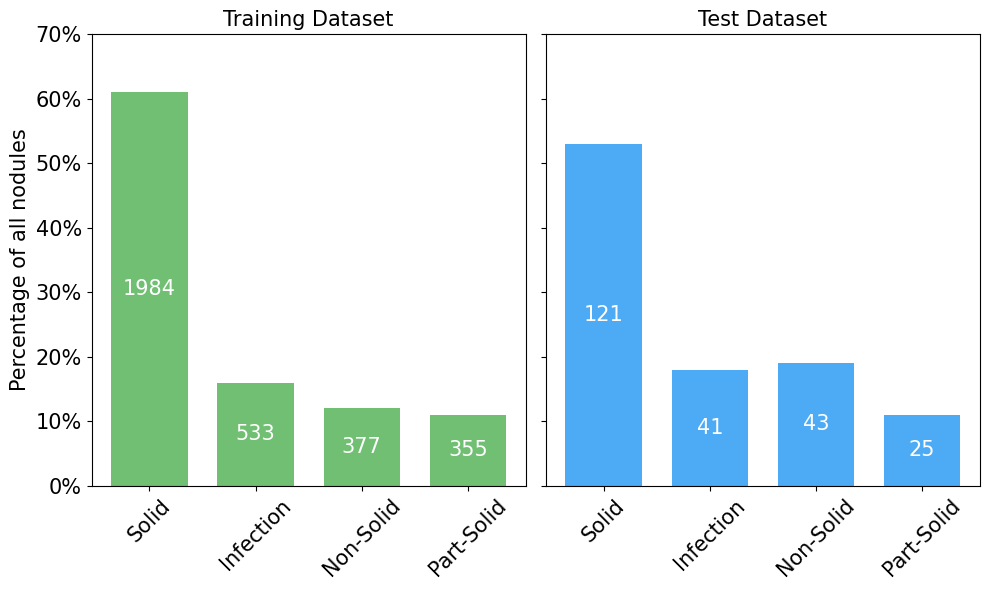

Chi-square Test Results:
Chi2 Statistic: 11.75107490490566
P-value: 0.008286386201001958
Degrees of Freedom: 3
Expected Frequencies:
[[1965.83644725  139.16355275]
 [ 536.05231388   37.94768612]
 [ 392.2334004    27.7665996 ]
 [ 354.87783846   25.12216154]]
There is a statistically significant difference between the training and test datasets.


,training,test
PERIFISSURAL,3292,0
SOLID,1984,168
CALCIFIED,533,0
NON_SOLID,377,20
PART_SOLID,355,74


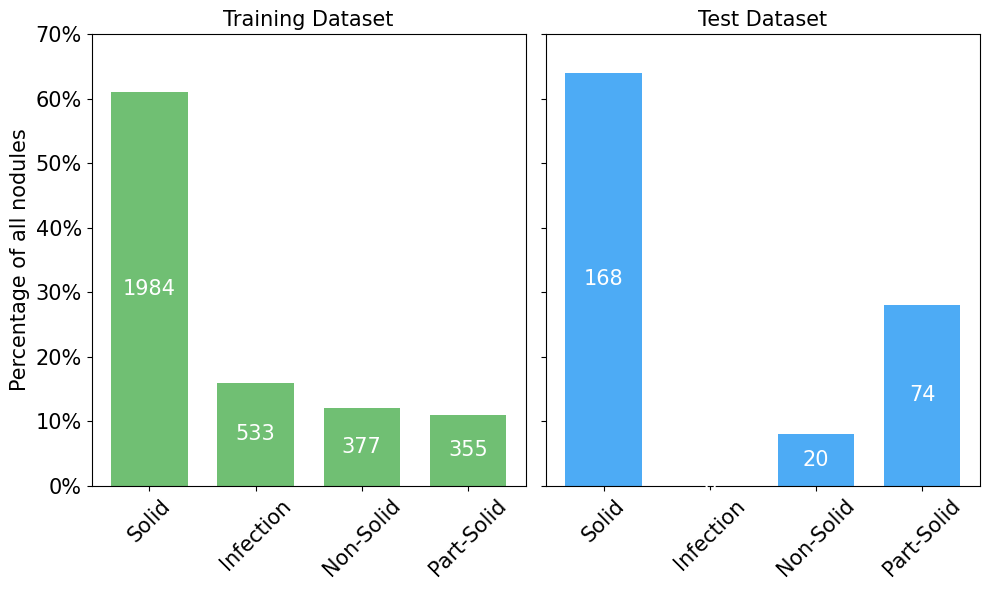

Chi-square Test Results:
Chi2 Statistic: 106.23908155989184
P-value: 7.072785046744214e-23
Degrees of Freedom: 3
Expected Frequencies:
[[1991.4121333   160.5878667 ]
 [ 493.2261464    39.7738536 ]
 [ 367.37482199   29.62517801]
 [ 396.98689832   32.01310168]]
There is a statistically significant difference between the training and test datasets.


In [246]:
from scipy.stats import chi2_contingency
import test

lsut_maps = {
    'CALCIFIED': 'CALCIFIED',
    'NON-SOLID': 'NON_SOLID',
    'PART-SOLID': 'PART_SOLID',
    'SOLID': 'SOLID',
    'PERIFISSURAL': 'PERIFSSURAL'
}


colors = {
    'SOLID' : '#1f77b4',  # Blue
    'PART_SOLID' : '#ff7f0e',    # Orange
    'NON_SOLID' : '#2ca02c',   # Green
    'CALCIFIED' : 'grey',    # Purple
}

category_mappings = {
    'SOLID' : 'Solid',
    'PART_SOLID' : 'Part-Solid',
    'NON_SOLID' : 'Non-Solid',
    'CALCIFIED' : 'Infection'
}

for dataset in ['summit', 'lsut']:
    
    training_nodule_vc = pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_type'])['nodule_type'].value_counts().rename('training')

    if dataset == 'summit':
        test_nodule_vc = (
            pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_type'])
            .assign(Actionable=lambda df: df['management_plan'] != 'RANDOMISATION_AT_YEAR_1')
            .query('Actionable == True')['nodule_type']
            .value_counts()
            .rename('test')
        )
    else:
        test_nodule_vc = (
            pd.read_csv('../../metadata/lsut/lsut_metadata.csv',usecols=['actionable', 'nodule_type'])
            .query('actionable == True')['nodule_type']
            .map(lsut_maps)
            .value_counts()
            .rename('test')
        )        





    nodule_vc = pd.concat([training_nodule_vc, test_nodule_vc], axis=1).fillna(0).astype(int)

    display(nodule_vc)

    nodule_vc = nodule_vc[(nodule_vc.index != 'PERIFISSURAL')]
    nodule_vc.index = nodule_vc.index.map(category_mappings)

    nodule_vc['training_percentage'] = np.round((nodule_vc['training'] / nodule_vc['training'].sum()) * 100)
    nodule_vc['test_percentage'] = np.round((nodule_vc['test'] / nodule_vc['test'].sum()) * 100)

    # Define bar width and positions
    bar_width = 0.4
    positions = np.arange(len(nodule_vc.index))

    # Create subplots for training and test data
    fig, axes = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

    # Define modern colors
    training_color = '#4CAF50'  # Green
    test_color = '#2196F3'      # Blue

    # Plot training percentages
    bars1 = axes[0].bar(positions, nodule_vc['training_percentage'], bar_width * 1.8, label='Training', alpha=0.8, color=training_color)
    for bar, absolute in zip(bars1, nodule_vc['training']):
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')

    # Plot test percentages
    bars2 = axes[1].bar(positions, nodule_vc['test_percentage'], bar_width * 1.8, label='Test', alpha=0.8, color=test_color)
    for bar, absolute in zip(bars2, nodule_vc['test']):
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')
        # Set labels, titles, and ticks for training axis
        # axes[0].set_xlabel('Nodule Type', fontsize=15)
        axes[0].set_ylabel('Percentage of all nodules', fontsize=15)
        axes[0].set_title('Training Dataset', fontsize=15)
        axes[0].set_xticks(positions)
        axes[0].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[0].set_yticks(range(0, 71, 10))
        axes[0].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

        # Set labels, titles, and ticks for test axis
        # axes[1].set_xlabel('Nodule Type', fontsize=15)
        axes[1].set_title('Test Dataset', fontsize=15)
        axes[1].set_xticks(positions)
        axes[1].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[1].set_yticks(range(0, 71, 10))
        axes[1].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

    # Show the plot
    plt.tight_layout()
    plt.savefig('results/extension/images/summit_nodule_type_distribution.png', bbox_inches='tight')
    plt.show()


    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(nodule_vc[['training', 'test']])

    print("Chi-square Test Results:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)

    if p < 0.05:
        print("There is a statistically significant difference between the training and test datasets.")
    else:
        print("There is no statistically significant difference between the training and test datasets.")

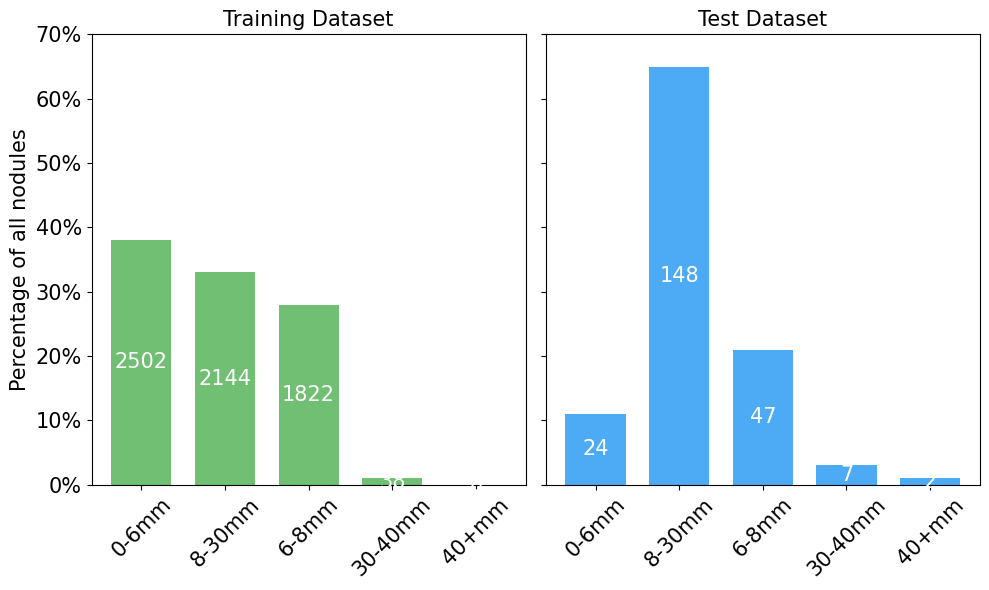

Chi-square Test Results:
Chi2 Statistic: 145.22401951516736
P-value: 2.147600603794828e-30
Degrees of Freedom: 4
Expected Frequencies:
[[2.44057609e+03 8.54239098e+01]
 [2.21448947e+03 7.75105310e+01]
 [1.80579442e+03 6.32055770e+01]
 [4.34781964e+01 1.52180362e+00]
 [9.66182142e+00 3.38178582e-01]]
There is a statistically significant difference between the training and test datasets.


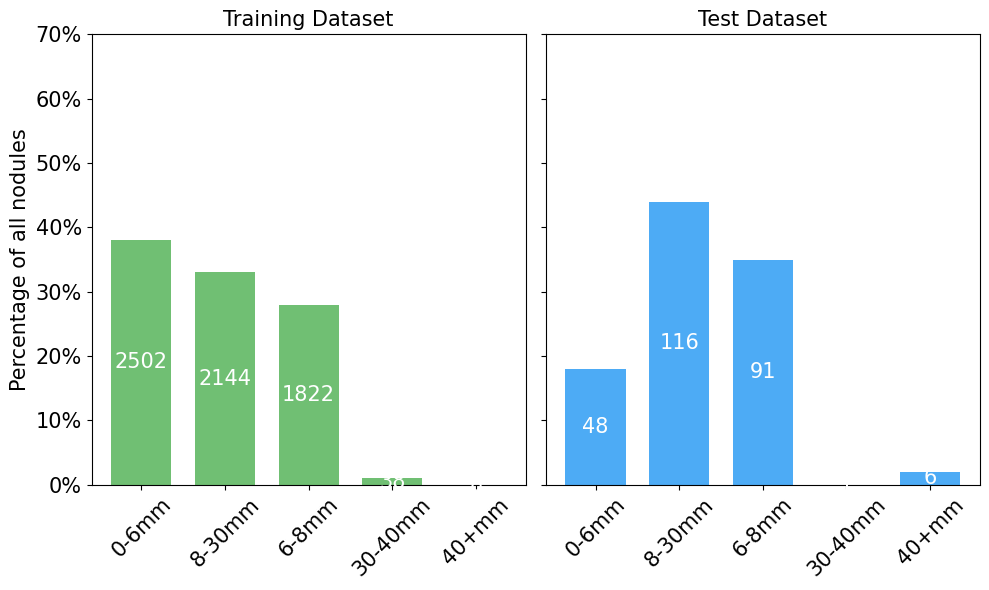

Chi-square Test Results:
Chi2 Statistic: 98.27393830313247
P-value: 2.2921525437503482e-20
Degrees of Freedom: 4
Expected Frequencies:
[[2.45140201e+03 9.85979929e+01]
 [2.17261511e+03 8.73848878e+01]
 [1.83903217e+03 7.39678276e+01]
 [3.74920307e+01 1.50796930e+00]
 [1.34586777e+01 5.41322314e-01]]
There is a statistically significant difference between the training and test datasets.


In [ ]:
from scipy.stats import chi2_contingency

colors = {
    '0-6mm' : 'blue', 
    '6-8mm' : 'orange', 
    '8-30mm' : 'green', 
    '30-40mm' : 'grey', 
    '40+mm' : 'purple'
}

category_mappings = {
    '0-6mm' : '0-6mm', 
    '6-8mm' : '6-8mm', 
    '8-30mm' : '8-30mm', 
    '30-40mm' : '30-40mm', 
    '40+mm' : '40+mm'
}

diameter_cats = [0, 6, 8, 30, 40, 999]

diameter_lbs = [
    '0-6mm',
    '6-8mm',
    '8-30mm',
    '30-40mm',
    '40+mm'
] 

for dataset in ['summit', 'lsut']:
    
    training_nodule_vc = (
        pd.read_csv('../../metadata/summit/test_balanced/training_metadata.csv', usecols=['nodule_diameter_mm'])
        .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']          
        .value_counts()
        .rename('training')
    )

    if dataset == 'summit':
        test_nodule_vc = (
            pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_diameter_mm'])
            .query('management_plan != "RANDOMISATION_AT_YEAR_1"')
            .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']         
            .value_counts()
            .rename('test')
        )

    else:
        test_nodule_vc = (
            pd.read_csv('../../metadata/lsut/lsut_metadata.csv',usecols=['actionable', 'nodule_diameter_mm'])
            .query('actionable == True')
            .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats,labels=diameter_lbs))['diameter_cats']
            .value_counts()
            .rename('test')
        )        

    nodule_vc = pd.concat([training_nodule_vc, test_nodule_vc], axis=1).fillna(0).astype(int)

    nodule_vc['training_percentage'] = np.round((nodule_vc['training'] / nodule_vc['training'].sum()) * 100)
    nodule_vc['test_percentage'] = np.round((nodule_vc['test'] / nodule_vc['test'].sum()) * 100)

    # Define bar width and positions
    bar_width = 0.4
    positions = np.arange(len(nodule_vc.index))

    # Create subplots for training and test data
    fig, axes = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

    # Define modern colors
    training_color = '#4CAF50'  # Green
    test_color = '#2196F3'      # Blue

    # Plot training percentages
    bars1 = axes[0].bar(positions, nodule_vc['training_percentage'], bar_width * 1.8, label='Training', alpha=0.8, color=training_color)
    for bar, absolute in zip(bars1, nodule_vc['training']):
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')

    # Plot test percentages
    bars2 = axes[1].bar(positions, nodule_vc['test_percentage'], bar_width * 1.8, label='Test', alpha=0.8, color=test_color)
    for bar, absolute in zip(bars2, nodule_vc['test']):
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{absolute}', ha='center', va='center', fontsize=15, color='white')
        # Set labels, titles, and ticks for training axis
        # axes[0].set_xlabel('Nodule Type', fontsize=15)
        axes[0].set_ylabel('Percentage of all nodules', fontsize=15)
        axes[0].set_title('Training Dataset', fontsize=15)
        axes[0].set_xticks(positions)
        axes[0].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[0].set_yticks(range(0, 71, 10))
        axes[0].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

        # Set labels, titles, and ticks for test axis
        # axes[1].set_xlabel('Nodule Type', fontsize=15)
        axes[1].set_title('Test Dataset', fontsize=15)
        axes[1].set_xticks(positions)
        axes[1].set_xticklabels(nodule_vc.index, fontsize=15, rotation=45)
        axes[1].set_yticks(range(0, 71, 10))
        axes[1].set_yticklabels([f'{ytick}%' for ytick in range(0, 71, 10)], fontsize=15)

    # Show the plot
    plt.tight_layout()
    plt.savefig('results/extension/images/summit_nodule_diameter_distribution.png', bbox_inches='tight')
    plt.show()


    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(nodule_vc[['training', 'test']])

    print("Chi-square Test Results:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)

    if p < 0.05:
        print("There is a statistically significant difference between the training and test datasets.")
    else:
        print("There is no statistically significant difference between the training and test datasets.")

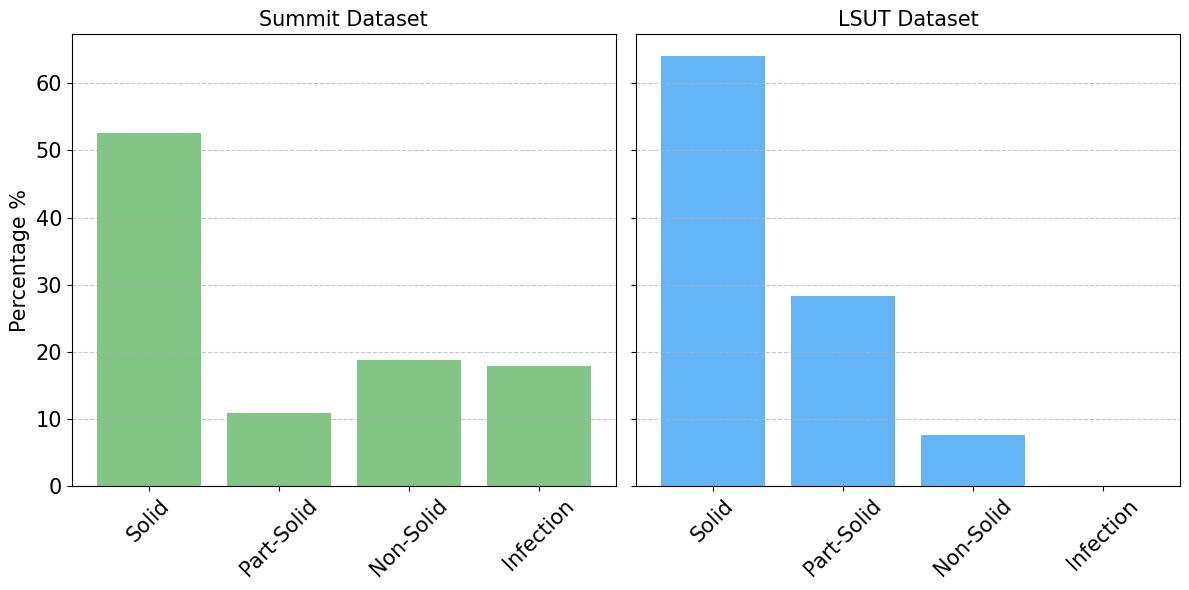

Chi-square Test Results:
Chi2 Statistic: 110.90865913377905
P-value: 9.602696797128949e-20
Degrees of Freedom: 9
Expected Frequencies:
[[134.85273353 153.61485298  58.63162327  58.63162327]
 [ 45.90488903  52.2916562   19.9586474   19.9586474 ]
 [ 29.69035432  33.82118623  12.90884971  12.90884971]
 [ 19.55202312  22.2723046    8.50087962   8.50087962]]
There is a statistically significant difference between the two datasets.


In [278]:
summit_test_nodule_vc = (
    pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_type'])
    .assign(Actionable=lambda df: df['management_plan'] != 'RANDOMISATION_AT_YEAR_1')
    .query('Actionable == True')['nodule_type']
    .value_counts()
    .reindex(['SOLID', 'PART_SOLID', 'NON_SOLID', 'CALCIFIED'])
    .rename('test')
)

lsut_test_nodule_vc = (
    pd.read_csv('../../metadata/lsut/lsut_metadata.csv',usecols=['actionable', 'nodule_type'])
    .query('actionable == True')['nodule_type']
    .map(lsut_maps)
    .value_counts()
    .rename('test')
)  

category_mappings = {
    'SOLID' : 'Solid',
    'PART_SOLID' : 'Part-Solid',
    'NON_SOLID' : 'Non-Solid',
    'CALCIFIED' : 'Infection'
}
# Combine the two series into a DataFrame for chi-square test
combined_vc = pd.concat([summit_test_nodule_vc, lsut_test_nodule_vc], axis=1).fillna(0).astype(int)

combined_vc.rename(index=category_mappings, inplace=True)

combined_vc.columns = ['summit', 'lsut']

# Calculate percentages
combined_vc['summit_percentage'] = (combined_vc['summit'] / combined_vc['summit'].sum()) * 100
combined_vc['lsut_percentage'] = (combined_vc['lsut'] / combined_vc['lsut'].sum()) * 100

# Plot the distributions side by side
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Summit dataset
summit_color = '#4CAF50'  # Green
lsut_color = '#2196F3'    # Blue

# Summit dataset percentages
axes[0].bar(combined_vc.index, combined_vc['summit_percentage'], color=summit_color, alpha=0.7)
axes[0].set_title('Summit Dataset', fontsize=15)
axes[0].set_ylabel('Percentage %', fontsize=15)
# axes[0].set_xlabel('Nodule Types', fontsize=15)
axes[0].set_xticks(range(len(combined_vc.index)))
axes[0].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# LSUT dataset percentages
axes[1].bar(combined_vc.index, combined_vc['lsut_percentage'], color=lsut_color, alpha=0.7)
axes[1].set_title('LSUT Dataset', fontsize=15)
# axes[1].set_xlabel('Nodule Types', fontsize=15)
axes[1].set_xticks(range(len(combined_vc.index)))
axes[1].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('results/extension/images/summit_vs_lsut_nodule_type_distribution.png', bbox_inches='tight')
plt.tight_layout()
plt.show()
# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(combined_vc)

print("Chi-square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

if p < 0.05:
    print("There is a statistically significant difference between the two datasets.")
else:
    print("There is no statistically significant difference between the two datasets.")

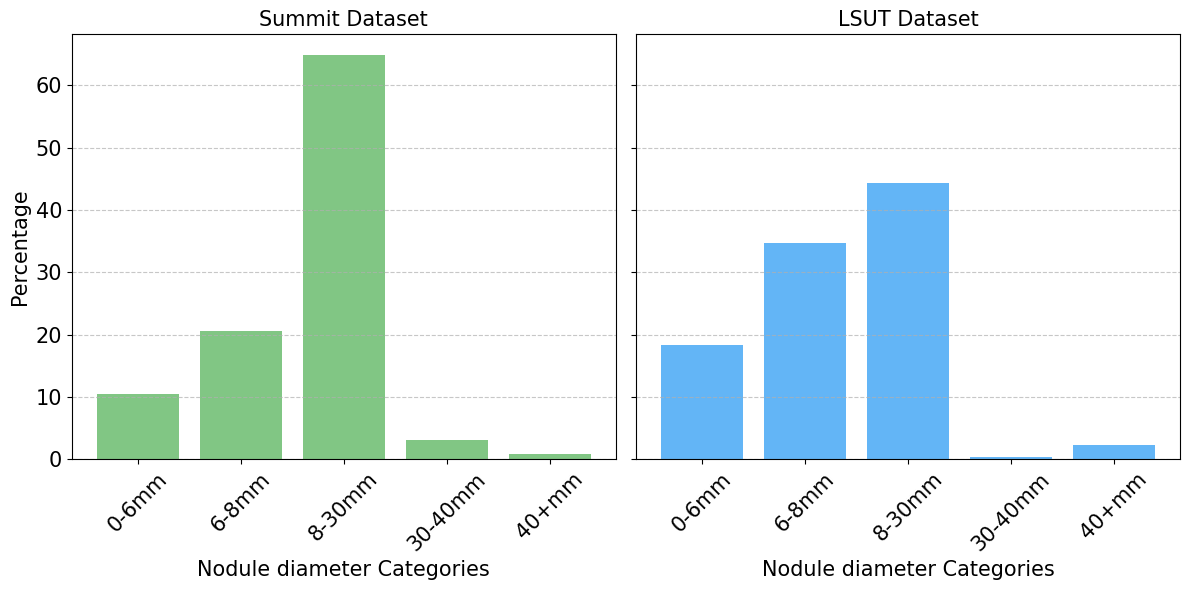

Chi-square Test Results:
Chi2 Statistic: 30.193963397226227
P-value: 4.468981997471203e-06
Degrees of Freedom: 4
Expected Frequencies:
[[ 33.50204082  38.49795918]
 [ 64.2122449   73.7877551 ]
 [122.84081633 141.15918367]
 [  3.72244898   4.27755102]
 [  3.72244898   4.27755102]]
There is a statistically significant difference between the two datasets.


In [279]:
summit_test_nodule_vc = (
    pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_diameter_mm'])
    .query('management_plan != "RANDOMISATION_AT_YEAR_1"')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']         
    .value_counts(normalize=True)
    .sort_index()
    .rename('test')
)

lsut_test_nodule_vc = (
    pd.read_csv('../../metadata/lsut/lsut_metadata.csv', usecols=['actionable', 'nodule_diameter_mm'])
    .query('actionable == True')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']
    .value_counts(normalize=True)
    .sort_index()
    .rename('test')
)  

# Combine the two series into a DataFrame for chi-square test
combined_vc = pd.concat([summit_test_nodule_vc, lsut_test_nodule_vc], axis=1).fillna(0)
combined_vc.columns = ['summit', 'lsut']

# Plot the distributions side by side
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Summit dataset
summit_color = '#4CAF50'  # Green
lsut_color = '#2196F3'    # Blue

# Summit dataset percentages
axes[0].bar(combined_vc.index, combined_vc['summit'] * 100, color=summit_color, alpha=0.7)
axes[0].set_title('Summit Dataset', fontsize=15)
axes[0].set_ylabel('Percentage', fontsize=15)
axes[0].set_xlabel('Nodule diameter Categories', fontsize=15)
axes[0].set_xticks(range(len(combined_vc.index)))
axes[0].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# LSUT dataset percentages
axes[1].bar(combined_vc.index, combined_vc['lsut'] * 100, color=lsut_color, alpha=0.7)
axes[1].set_title('LSUT Dataset', fontsize=15)
axes[1].set_xlabel('Nodule diameter Categories', fontsize=15)
axes[1].set_xticks(range(len(combined_vc.index)))
axes[1].set_xticklabels(combined_vc.index, rotation=45, fontsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('results/extension/images/summit_vs_lsut_nodule_diameter_distribution.png', bbox_inches='tight')
plt.tight_layout()
plt.show()




summit_test_nodule_vc = (
    pd.read_csv('../../metadata/summit/test_balanced/test_metadata.csv', usecols=['management_plan', 'nodule_diameter_mm'])
    .query('management_plan != "RANDOMISATION_AT_YEAR_1"')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']         
    .value_counts()
    .sort_index()
    .rename('test')
)

lsut_test_nodule_vc = (
    pd.read_csv('../../metadata/lsut/lsut_metadata.csv', usecols=['actionable', 'nodule_diameter_mm'])
    .query('actionable == True')
    .assign(diameter_cats=lambda df: pd.cut(df['nodule_diameter_mm'], bins=diameter_cats, labels=diameter_lbs))['diameter_cats']
    .value_counts()
    .sort_index()
    .rename('test')
)  

# Combine the two series into a DataFrame for chi-square test
combined_vc = pd.concat([summit_test_nodule_vc, lsut_test_nodule_vc], axis=1).fillna(0)
combined_vc.columns = ['summit', 'lsut']

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(combined_vc)

print("Chi-square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

if p < 0.05:
    print("There is a statistically significant difference between the two datasets.")
else:
    print("There is no statistically significant difference between the two datasets.")

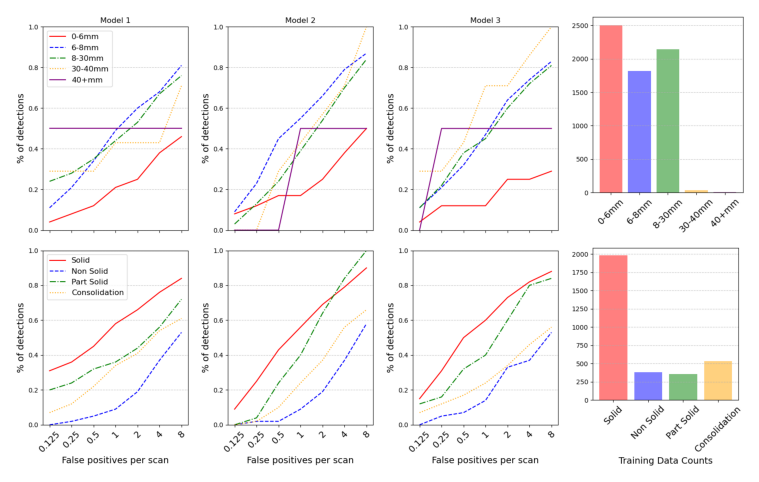

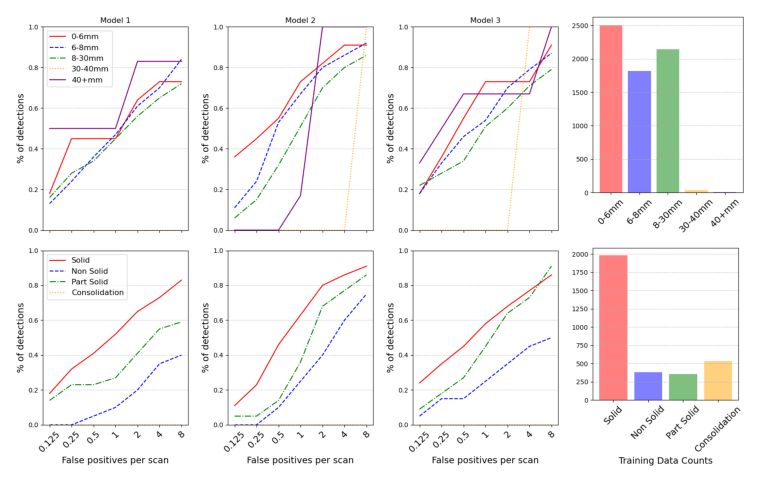

In [ ]:


for dataset in ['summit', 'lsut']:

    # Read the saved images
    img1 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_diameter_cats.png')
    img2 = Image.open(f'results/{dataset}/detection/test_balanced/Actionable/FROC/images/detection_nodule_characteristics_diameter_cats.png')
    img3 = Image.open(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/images/ticnet_nodule_characteristics_diameter_cats.png')
    img4 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_nodule_type.png')
    img5 = Image.open(f'results/{dataset}/detection/test_balanced/Actionable/FROC/images/detection_nodule_characteristics_nodule_type.png')
    img6 = Image.open(f'results/{dataset}/ticnet/test_balanced/Actionable/FROC/images/ticnet_nodule_characteristics_nodule_type.png')
    img7 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_total_diameter_cats.png')
    img8 = Image.open(f'results/{dataset}/grt123/test_balanced/Actionable/FROC/images/grt123_nodule_characteristics_total_nodule_type.png')

    # Get the size of the images
    width1, height1 = img1.size
    width2, height2 = img2.size
    width3, height3 = img3.size
    width4, height4 = img4.size
    width5, height5 = img5.size
    width6, height6 = img6.size
    width7, height7 = img7.size
    width8, height8 = img8.size


    # Create a new image with a size that can fit both images side by side
    combined_width = width1 + width2 + width3 + width7
    combined_height = max(height1, height2, height3, height7) + max(height4, height5, height6, height8)
    combined_img = Image.new("RGB", (combined_width, combined_height))

    # Paste the images into the combined image
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (width1, 0))
    combined_img.paste(img3, (width1 + width2, 0))
    combined_img.paste(img7, (width1 + width2 + width3, 0))
    combined_img.paste(img4, (0, height1))
    combined_img.paste(img5, (width1, height2))
    combined_img.paste(img6, (width1 + width2, height3))
    combined_img.paste(img8, (width1 + width2 + width3, height7))

    # Save the combined image
    combined_img.save(f'results/extension/images/{dataset}_nodule_characteristics.png')

    # Display the combined image using matplotlib
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(combined_img)
    ax.axis('off')  # Hide the axis
    plt.show()

In [109]:
# Scan acquistion information
import numpy as np

summit_lung_metadata = pd.read_csv('../../data/summit/lung_metadata.csv')
lsut_lung_metadata = pd.read_csv('../../data/lsut/lung_metadata.csv')

print(lsut_lung_metadata['x-spacing'].describe())
print(lsut_lung_metadata['z-spacing'].describe())


summit_lung_metadata['z-spacing'].value_counts(normalize=True).sort_index()


count    732.000000
mean       0.676806
std        0.065008
min        0.512000
25%        0.625000
50%        0.665000
75%        0.723000
max        0.976000
Name: x-spacing, dtype: float64
count    732.000000
mean       0.745928
std        0.155219
min        0.299999
25%        0.800000
50%        0.800000
75%        0.800000
max        0.800000
Name: z-spacing, dtype: float64


0.625000    0.999454
0.626310    0.000032
0.627790    0.000032
0.642641    0.000032
0.649655    0.000032
0.665126    0.000032
0.686141    0.000032
0.698775    0.000032
0.705735    0.000032
0.706395    0.000032
0.861667    0.000032
1.000000    0.000225
Name: z-spacing, dtype: float64

# Statistical Analysis

In [29]:
import numpy as np
import cv2
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from scipy import stats

def hist_comparison(data1, cat1, data2, cat2, bins, title, variable, density=True):

    hist1, bins1 = np.histogram(data1[variable], bins=bins, density=True)
    hist2, bins2 = np.histogram(data2[variable], bins=bins, density=True)

    hist1 = cv2.normalize(hist1, hist1).astype(np.float32)
    hist2 = cv2.normalize(hist2, hist2).astype(np.float32)

    print(f'Histogram comparison for {variable} for {title}')
    print(f'Correlation between {variable} and nodule diameter for {title} is {cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)}')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].hist(data1[variable], bins=bins, density=density, alpha=0.6, color='red')
    ax[0].set_title(f'{variable} for {cat1} ppts')
    if density:
        ax[0].set_xlim(0, 80)
        ax[0].set_ylim(0, 0.2)


    ax[1].hist(data2[variable], bins=bins, density=density, alpha=0.6, color='blue')
    ax[1].set_title(f'{variable} for {cat2} ppts')
    if density:
        ax[1].set_xlim(0, 80)
        ax[1].set_ylim(0, 0.2)
    

    fig.suptitle(title)
    plt.show()

def differences_bar_chart(data1, cat1, data2, cat2, variable, title):

    values1 = data1[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat1}').to_frame()
    values2 = data2[variable].value_counts(normalize=True).sort_index().rename(f'{variable}_{cat2}').to_frame()

    values = values1.merge(values2, left_index=True, right_index=True, how='outer').fillna(0)

    # Calculate differences
    differences = values[f'{variable}_{cat1}'] - values[f'{variable}_{cat2}']

    display(differences)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(differences.index, differences, color=['blue' if value < 0 else 'red' for value in differences])


    # Add labels and title
    ax.set_xticklabels(differences.index, rotation=45)
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Difference')
    ax.set_title(f'Difference Bar Chart: {variable}')
    # Function to format y-tick labels as percentages with sign
    def percentage_with_sign(x, pos):
        return f'{np.abs(x)*100:.0f}%'

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_with_sign))


    positive_patch = Patch(color='red', label=f'{cat1} greater than {cat2}')
    negative_patch = Patch(color='blue', label=f'{cat2} greater than {cat1}')
    ax.legend(handles=[positive_patch, negative_patch])

    # Show the plot
    plt.show()

def chi_square_test(data1, cat1, data2, cat2, variable):
    # Create the crosstab with absolutes
    xabs = (
        pd.DataFrame(
            data1[variable]
            .value_counts()
            .sort_index()
        )
        .merge(
            pd.DataFrame(
                data2[variable]
                .value_counts()
                .sort_index()
            ),
            left_index=True,
            right_index=True,
            how='outer',
            suffixes=('_'+cat1, '_'+cat2))
        .fillna(0)
    ).astype(int)

    # Calculate the chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(xabs)

    print(f'Chi-square test for {variable} between {cat1} and {cat2}')
    print(f'Chi2: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies table:')
    # display(pd.DataFrame(expected, index=xabs.index, columns=xabs.columns))

    return chi2, p, dof, expected

nodule_type,CALCIFIED,NON_SOLID,PART_SOLID,SOLID,All
ethnic_group,,,,,
Asian or Asian British,0.104651,0.093023,0.069767,0.232558,0.5
Black,0.094595,0.108108,0.027027,0.270270,0.5
White,0.054878,0.103659,0.030488,0.310976,0.5
All,0.077160,0.101852,0.040123,0.280864,0.5


nodule_type,CALCIFIED,NON_SOLID,PART_SOLID,SOLID,All
ethnic_group,,,,,
Asian or Asian British,0.076923,0.146154,0.046154,0.230769,0.5
Black,0.080645,0.088710,0.032258,0.298387,0.5
White,0.101942,0.063107,0.072816,0.262136,0.5
All,0.089130,0.093478,0.054348,0.263043,0.5


Chi-square test results:
Chi2: 13.744180865300782
p-value: 0.5450128854167515
Degrees of freedom: 15
Expected frequencies table:
[[  7.85204082  11.14795918]
 [ 11.15816327  15.84183673]
 [  4.95918367   7.04081633]
 [ 20.66326531  29.33673469]
 [  7.0255102    9.9744898 ]
 [  7.85204082  11.14795918]
 [  2.47959184   3.52040816]
 [ 23.55612245  33.44387755]
 [ 12.39795918  17.60204082]
 [ 12.39795918  17.60204082]
 [  8.26530612  11.73469388]
 [ 43.39285714  61.60714286]
 [ 27.2755102   38.7244898 ]
 [ 31.40816327  44.59183673]
 [ 15.70408163  22.29591837]
 [ 87.6122449  124.3877551 ]]


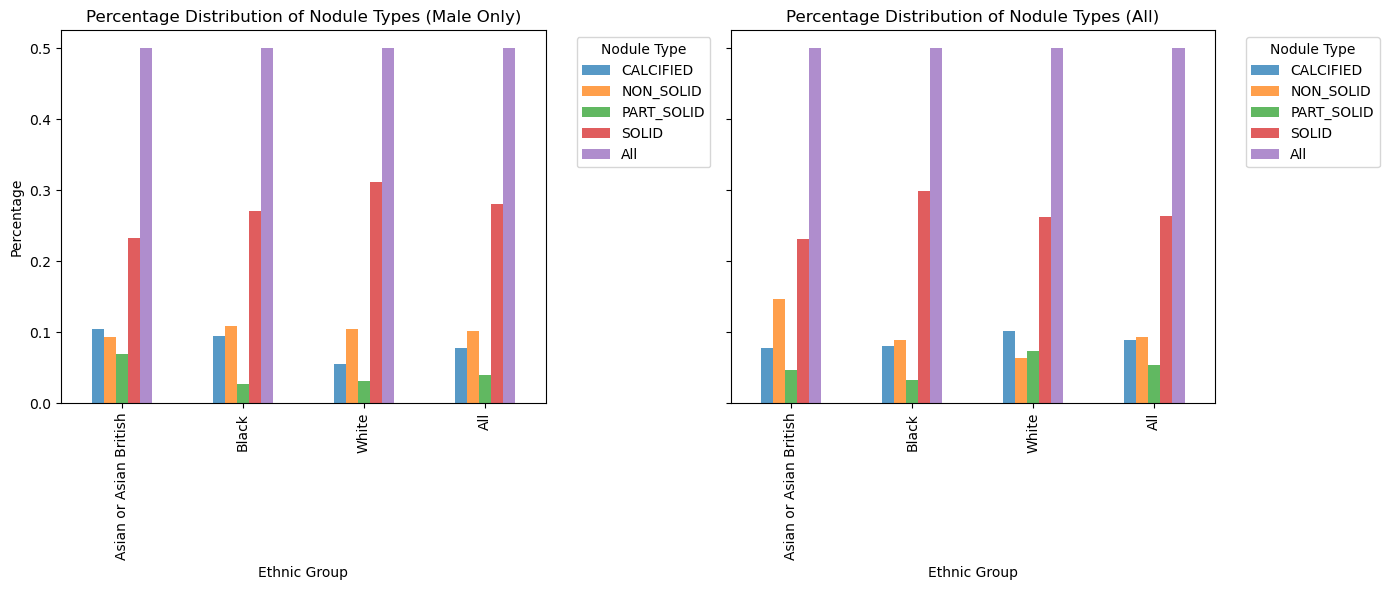

In [48]:
import matplotlib.pyplot as plt

def get_xtab(data):
    crosstab = pd.crosstab(
        data['ethnic_group'],
        data['nodule_type'],
        margins="index",
    )
    crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0)

    crosstab_combined = crosstab.astype(str) + ' (' + crosstab_percentage.astype(str) + ')' 

    return crosstab, crosstab_percentage, crosstab_combined

data = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/male_only/test_metadata.csv')
data = data.query('management_plan != "RANDOMISATION_AT_YEAR_1"')
mo_abs, mo_perc, mo_combined = get_xtab(data)

data = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/test_balanced/test_metadata.csv')
data = data.query('management_plan != "RANDOMISATION_AT_YEAR_1"')
all_abs, all_perc, all_combined = get_xtab(data)

display(mo_perc)
display(all_perc)

# Unravel mo_abs and all_abs
mo_abs_unravel = mo_abs.drop('All', axis=1).stack().reset_index().rename(columns={0: 'count'}).assign(ethnic_grp_and_subtype=lambda df: df.ethnic_group + '_' + df.nodule_type).drop(columns=['ethnic_group', 'nodule_type'])
all_abs_unravel = all_abs.drop('All', axis=1).stack().reset_index().rename(columns={0: 'count'}).assign(ethnic_grp_and_subtype=lambda df: df.ethnic_group + '_' + df.nodule_type).drop(columns=['ethnic_group', 'nodule_type'])

combined_long = pd.merge(mo_abs_unravel, all_abs_unravel, on='ethnic_grp_and_subtype', suffixes=('_mo', '_all'))

# Run chi-square test
chi2, p, dof, expected = stats.chi2_contingency(combined_long[['count_mo', 'count_all']])

print(f'Chi-square test results:')
print(f'Chi2: {chi2}')
print(f'p-value: {p}')
print(f'Degrees of freedom: {dof}')
print(f'Expected frequencies table:')
print(expected)

# Plotting side by side bar plots for mo_perc and all_perc

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Plot for mo_perc
mo_perc.plot(kind='bar', ax=axes[0], alpha=0.75)
axes[0].set_title('Percentage Distribution of Nodule Types (Male Only)')
axes[0].set_xlabel('Ethnic Group')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Nodule Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for all_perc
all_perc.plot(kind='bar', ax=axes[1], alpha=0.75)
axes[1].set_title('Percentage Distribution of Nodule Types (All)')
axes[1].set_xlabel('Ethnic Group')
axes[1].legend(title='Nodule Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
